In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f22b077ee3065a6a0a3b50c99ec7083670748fad1bf372a5672d447fd6003a59
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler, Imputer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.appName("Yelp Business Classification").getOrCreate()

business_df = spark.read.csv("yelp_business.csv", header=True, inferSchema=True)
attributes_df = spark.read.csv("yelp_business_attributes.csv", header=True, inferSchema=True)
data = business_df.join(attributes_df, on="business_id")

data = data.withColumn("review_count", data["review_count"].cast("int"))

categorical_columns = [
    "name", "neighborhood", "address", "city", "state", "postal_code", "categories",
    # Removed 'AcceptsInsurance' from the list of categorical columns
    "ByAppointmentOnly", "BusinessAcceptsCreditCards",
    "BusinessParking_garage", "BusinessParking_street", "BusinessParking_validated",
    "BusinessParking_lot", "BusinessParking_valet", "HairSpecializesIn_coloring",
    "HairSpecializesIn_africanamerican", "HairSpecializesIn_curly", "HairSpecializesIn_perms",
    "HairSpecializesIn_kids", "HairSpecializesIn_extensions", "HairSpecializesIn_asian",
    "HairSpecializesIn_straightperms", "RestaurantsPriceRange2", "GoodForKids", "WheelchairAccessible",
    "BikeParking", "Alcohol", "HasTV", "NoiseLevel", "RestaurantsAttire", "Music_dj",
    "Music_background_music", "Music_no_music", "Music_karaoke", "Music_live", "Music_video",
    "Music_jukebox", "Ambience_romantic", "Ambience_intimate", "Ambience_classy",
    "Ambience_hipster", "Ambience_divey", "Ambience_touristy", "Ambience_trendy",
    "Ambience_upscale", "Ambience_casual", "RestaurantsGoodForGroups", "Caters",
    "WiFi", "RestaurantsReservations", "RestaurantsTakeOut", "HappyHour", "GoodForDancing",
    "RestaurantsTableService", "OutdoorSeating", "RestaurantsDelivery", "BestNights_monday",
    "BestNights_tuesday", "BestNights_friday", "BestNights_wednesday", "BestNights_thursday",
    "BestNights_sunday", "BestNights_saturday", "GoodForMeal_dessert", "GoodForMeal_latenight",
    "GoodForMeal_lunch", "GoodForMeal_dinner", "GoodForMeal_breakfast", "GoodForMeal_brunch",
    "CoatCheck", "Smoking", "DriveThru", "DogsAllowed", "BusinessAcceptsBitcoin",
    "Open24Hours", "BYOBCorkage", "BYOB", "Corkage", "DietaryRestrictions_dairy-free",
    "DietaryRestrictions_gluten-free", "DietaryRestrictions_vegan", "DietaryRestrictions_kosher",
    "DietaryRestrictions_halal", "DietaryRestrictions_soy-free", "DietaryRestrictions_vegetarian",
    "AgesAllowed", "RestaurantsCounterService"
]

numeric_columns = [
    "review_count", "latitude", "longitude", "stars"
]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="skip") for col in categorical_columns]

encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded") for col in categorical_columns]

imputer = Imputer(inputCols=numeric_columns, outputCols=numeric_columns)

feature_columns = [f"{col}_encoded" for col in categorical_columns] + numeric_columns

vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="stars")

pipeline = Pipeline(stages=indexers + encoders + [imputer, vector_assembler, scaler, rf])

train, test = data.randomSplit([0.8, 0.2], seed=42)

param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="stars"),
                          numFolds=3)

model_pipeline = crossval.fit(train)

predictions = model_pipeline.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="stars", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

print(f"Model accuracy: {accuracy:.4f}")

spark.stop()

NameError: name 'plt' is not defined

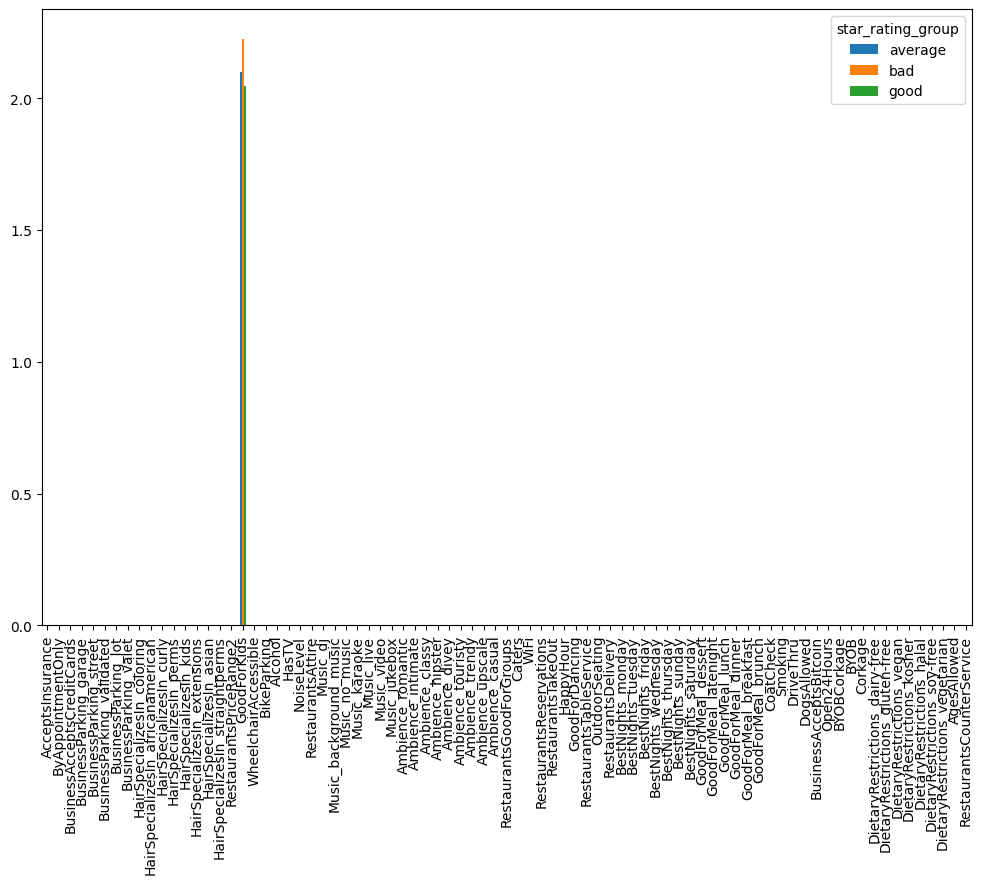

In [ ]:
from pyspark.sql.functions import when, mean
import matplotlib.pyplot as plt


merged_data = merged_data.withColumn(
    "star_rating_group",
    when(merged_data.stars < 3, "bad")
    .when(merged_data.stars == 3, "average")
    .otherwise("good")
)

attribute_columns = [col for col in yelp_business_attributes.columns if col != 'business_id']
grouped_data = merged_data.groupBy("star_rating_group").agg(
    *[mean(col).alias(col) for col in attribute_columns]
)

grouped_df = grouped_data.toPandas()

grouped_df.set_index("star_rating_group").transpose().plot(kind='bar', figsize=(12, 8))
plt.title('Average Presence of Attributes in Different Star Rating Groups')
plt.xlabel('Attributes')
plt.ylabel('Average Presence')
plt.legend(title='Star Rating Group')
plt.show()

spark.stop()



In [ ]:
import pandas as pd


yelp_attributes = pd.read_csv('yelp_business_attributes.csv')


def find_unique_responses(dataframe):

    unique_responses = {}
    for column in dataframe.columns:
        unique_responses[column] = dataframe[column].unique()

    return unique_responses
unique_responses_dict = find_unique_responses(yelp_attributes)

for attribute, responses in unique_responses_dict.items():
    print(f"Attribute: {attribute}")
    print(f"Unique Responses: {responses}")
    print()


Attribute: business_id
Unique Responses: ['FYWN1wneV18bWNgQjJ2GNg' 'He-G7vWjzVUysIKrfNbPUQ'
 '8DShNS-LuFqpEWIp0HxijA' ... 'XXvZBIHoJBU5d6-a-oyMWQ'
 'lNpPGgM96nPIYM1shxciHg' 'viKaP26BcHU6cLx8sf4gKg']

Attribute: AcceptsInsurance
Unique Responses: ['Na']

Attribute: ByAppointmentOnly
Unique Responses: ['Na' 'True' 'False']

Attribute: BusinessAcceptsCreditCards
Unique Responses: ['Na' 'False' 'True']

Attribute: BusinessParking_garage
Unique Responses: ['True' 'Na' 'False']

Attribute: BusinessParking_street
Unique Responses: ['Na' 'False' 'True']

Attribute: BusinessParking_validated
Unique Responses: ['Na' 'False' 'True']

Attribute: BusinessParking_lot
Unique Responses: ['Na' 'False' 'True']

Attribute: BusinessParking_valet
Unique Responses: ['Na' 'False' 'True']

Attribute: HairSpecializesIn_coloring
Unique Responses: ['Na' 'False' 'True']

Attribute: HairSpecializesIn_africanamerican
Unique Responses: ['Na' 'True']

Attribute: HairSpecializesIn_curly
Unique Responses: ['Na' 'False'

In [ ]:
import pandas as pd

yelp_attributes = pd.read_csv('yelp_business_attributes.csv')

unique_responses_set = set()

for column in yelp_attributes.columns:

    if column != 'business_id':
        unique_responses = yelp_attributes[column].unique()
        unique_responses_set.update(unique_responses)

combined_unique_responses = list(unique_responses_set)

print("Total unique responses:", len(combined_unique_responses))
print("First 25 unique responses:", combined_unique_responses[:25])


Total unique responses: 25
First 25 unique responses: ['average', 'Na', 'loud', 'False', '21plus', 'casual', 'paid', 'True', 'none', '18plus', 'allages', '1', 'free', '4', 'yes_corkage', 'very_loud', 'no', 'yes', 'yes_free', 'quiet', '3', 'outdoor', '2', 'full_bar', 'beer_and_wine']


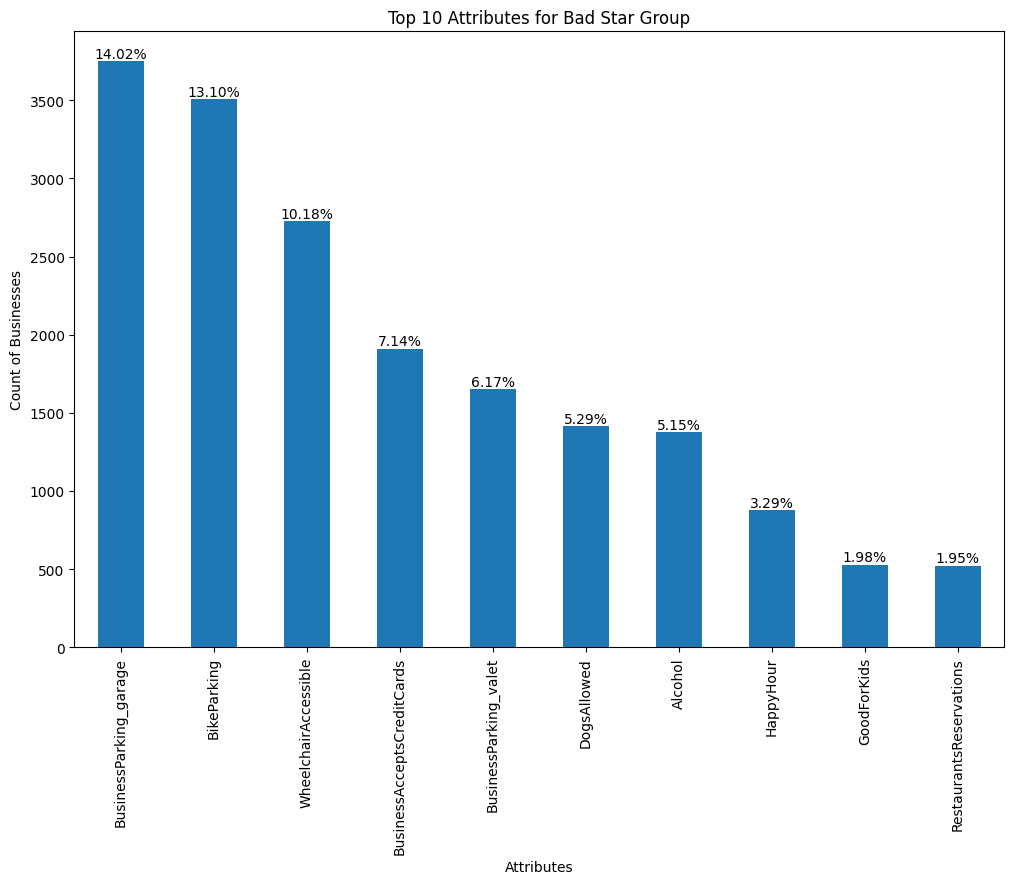

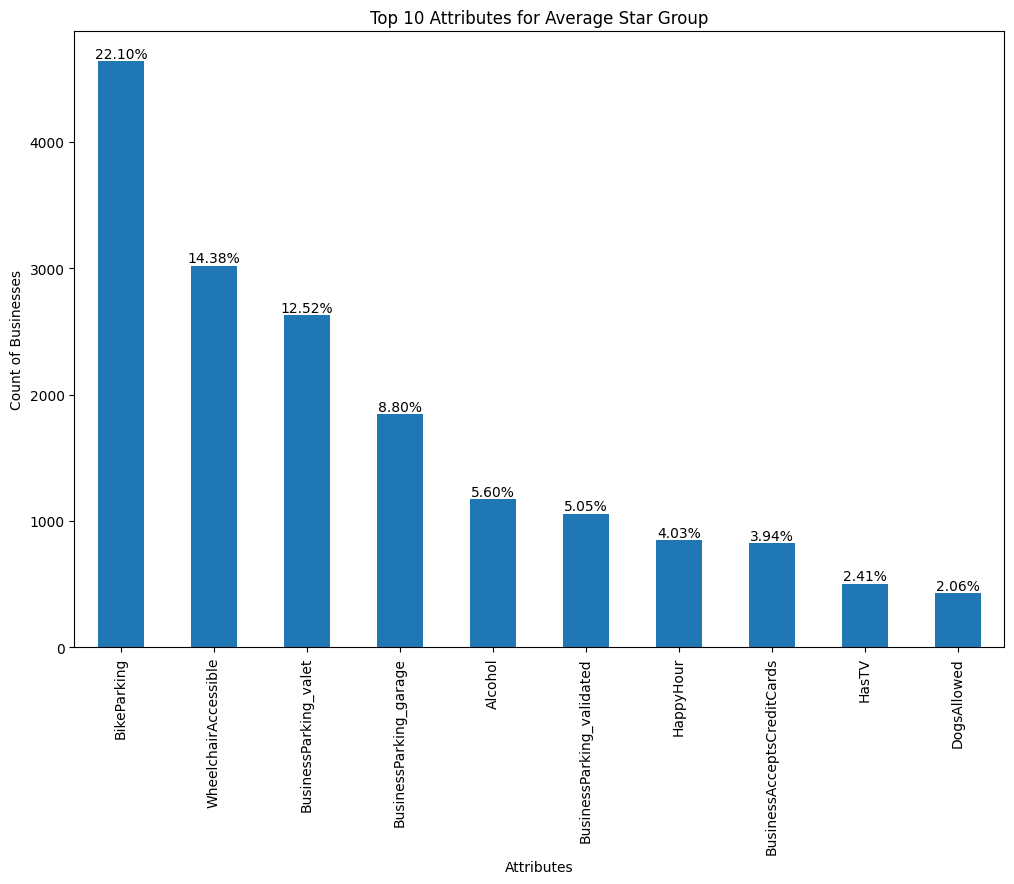

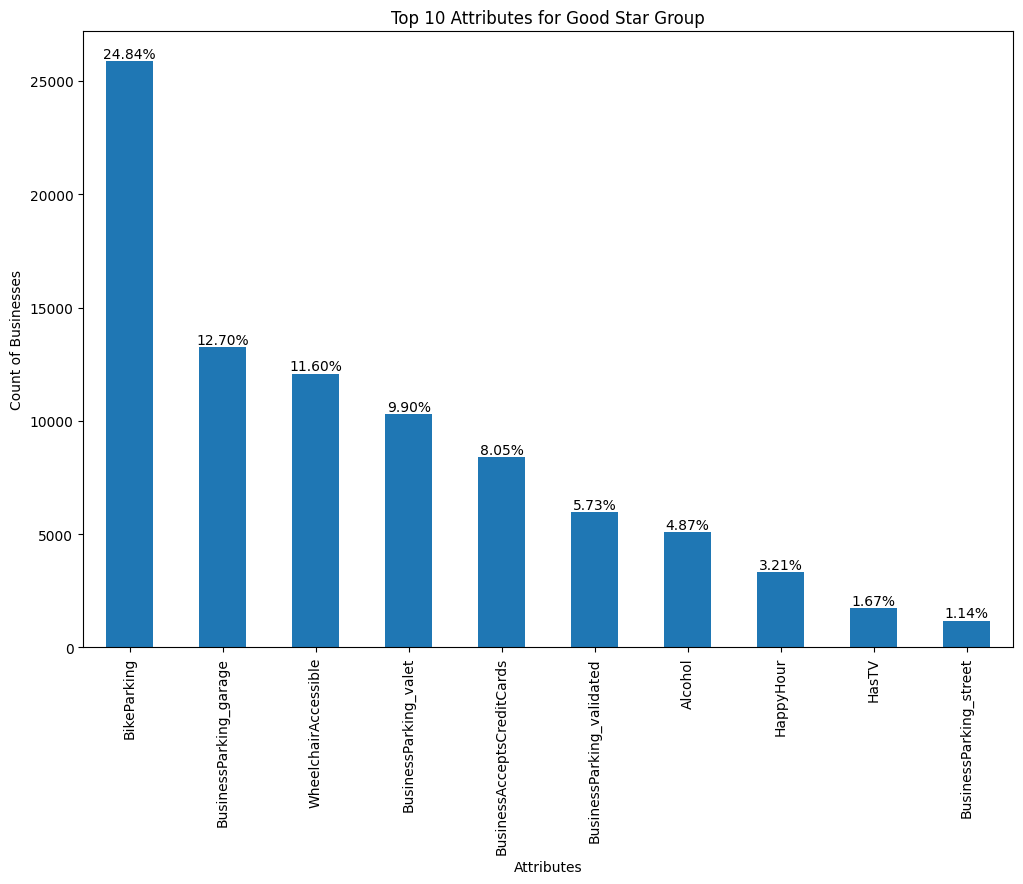

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

yelp_business = pd.read_csv('yelp_business.csv')
yelp_attributes = pd.read_csv('yelp_business_attributes.csv')

yelp_attributes = yelp_attributes.fillna(False)
yelp_attributes = yelp_attributes.replace({
    'True': True, 'False': False,
    'average': True, 'Na': False, 'loud': False,
    '21plus': True, 'casual': True, 'paid': False,
    'none': False, '18plus': True, 'allages': True, '1': False,
    'free': True, '4': True, 'yes_corkage': False, 'very_loud': False,
    'no': False, 'yes': True, 'yes_free': True, 'quiet': True, '3': True,
    'outdoor': True, '2': False, 'full_bar': True, 'beer_and_wine': True
})


merged_data = pd.merge(yelp_business, yelp_attributes, on='business_id')


def star_group(stars):
    if stars < 3:
        return 'Bad'
    elif stars == 3:
        return 'Average'
    else:
        return 'Good'

merged_data['star_group'] = merged_data['stars'].apply(star_group)

attributes = yelp_attributes.columns.difference(['business_id'])


total_counts = merged_data['star_group'].value_counts()

def get_top_10_attributes(data, star_group):

    attribute_counts = data.groupby('star_group')[attributes].sum().loc[star_group]

    top_10_attributes = attribute_counts.sort_values(ascending=False).head(10)

    top_10_attributes_percentage = (top_10_attributes / total_counts[star_group]) * 100

    return top_10_attributes, top_10_attributes_percentage


def plot_top_10_bar_graph(data, percentages, star_group, title):
    plt.figure(figsize=(12, 8))
    ax = data.plot(kind='bar')
    ax.set_title(title)
    ax.set_xlabel('Attributes')
    ax.set_ylabel('Count of Businesses')

    for i, v in enumerate(data):
        ax.text(i, v + 1, f"{percentages[i]:.2f}%", ha='center', va='bottom')

    plt.show()

for group in ['Bad', 'Average', 'Good']:
    top_10_attributes, top_10_percentages = get_top_10_attributes(merged_data, group)
    plot_top_10_bar_graph(top_10_attributes, top_10_percentages, group, f"Top 10 Attributes for {group} Star Group")


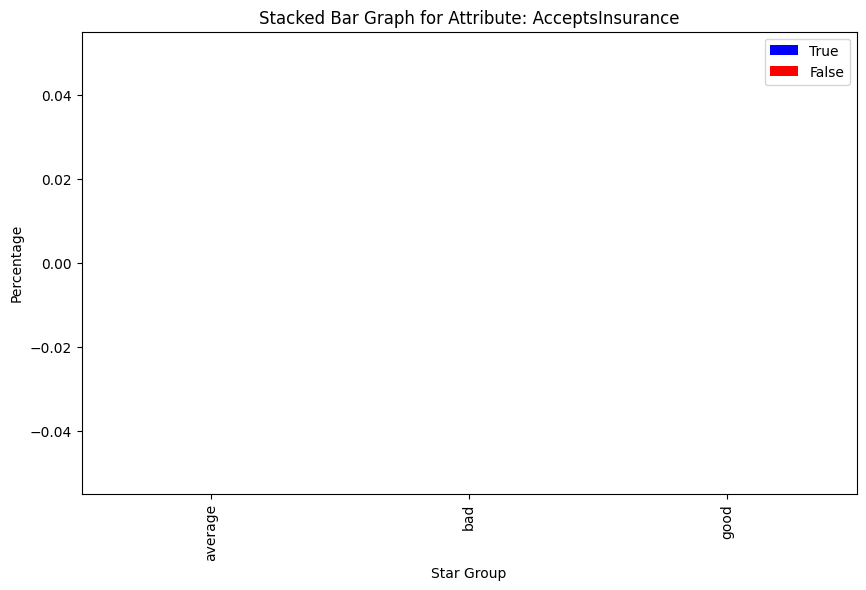

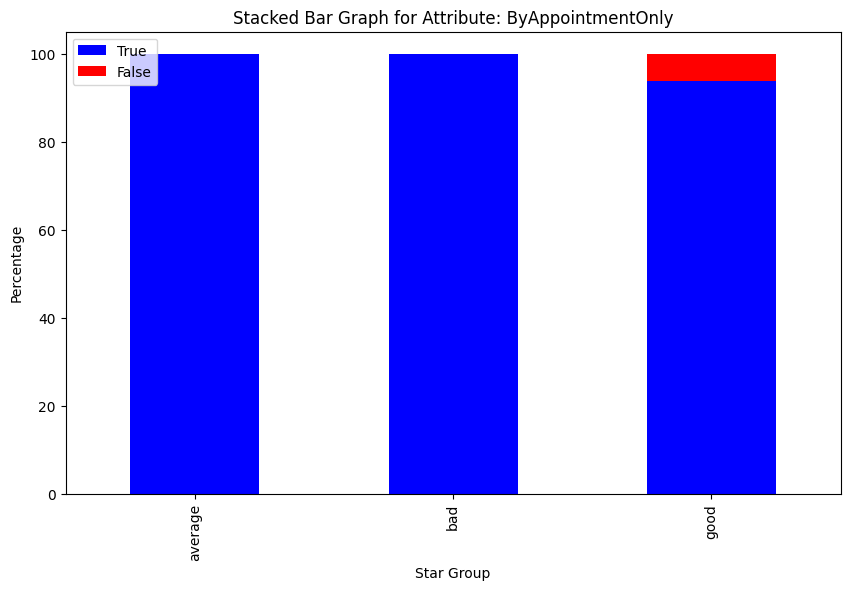

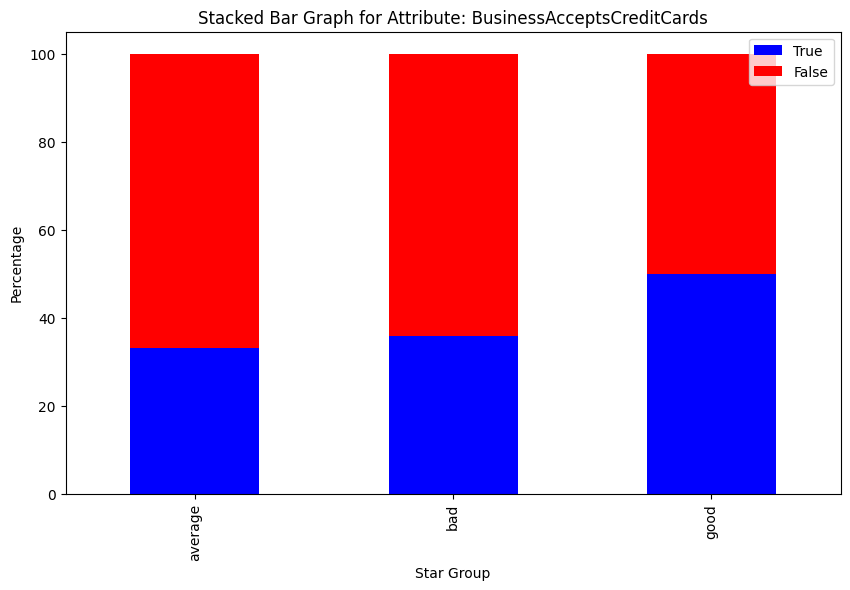

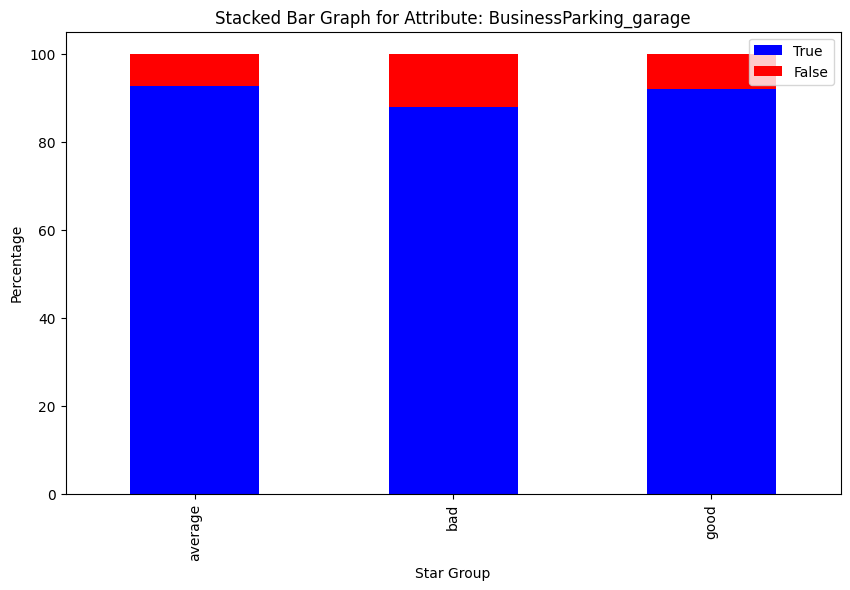

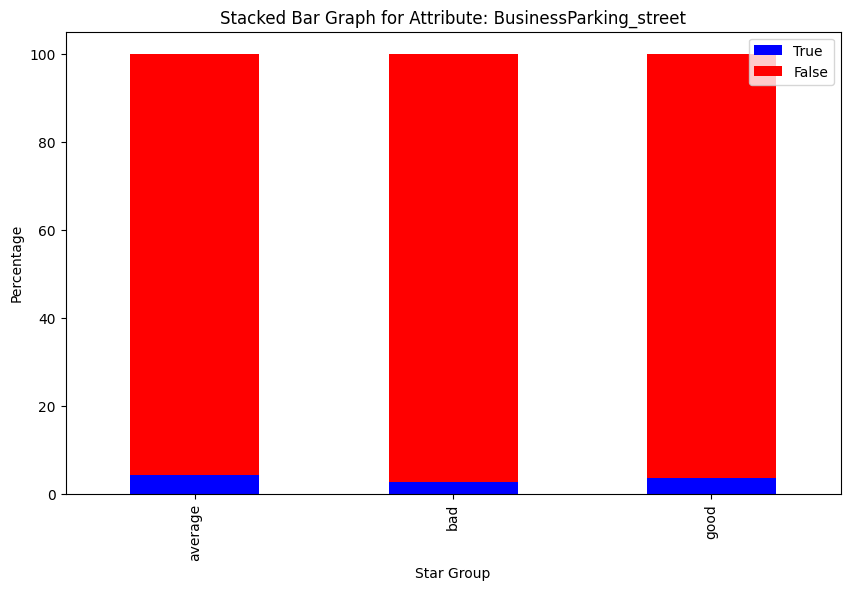

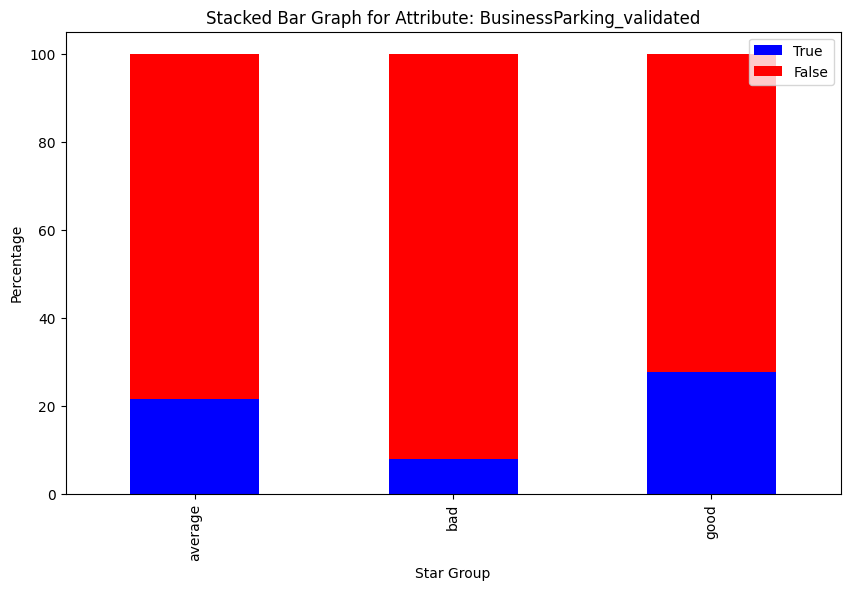

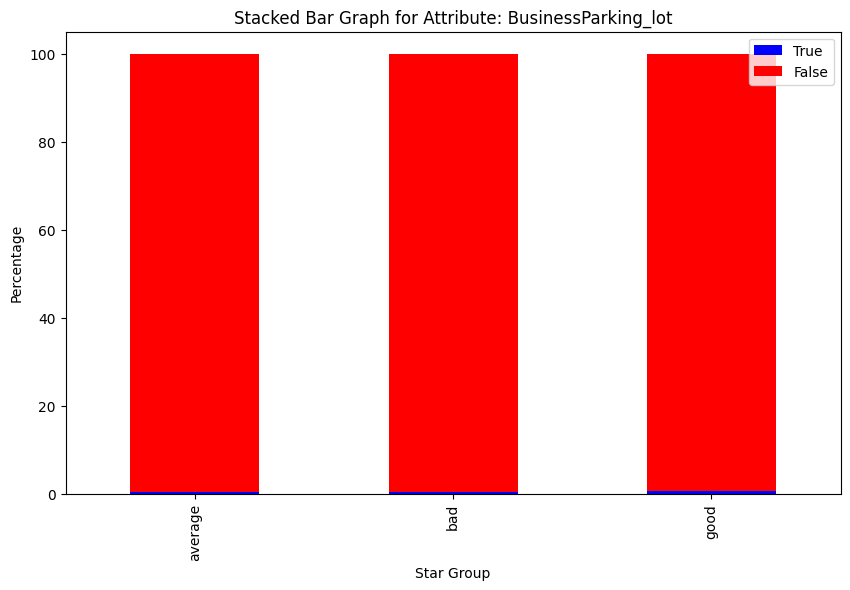

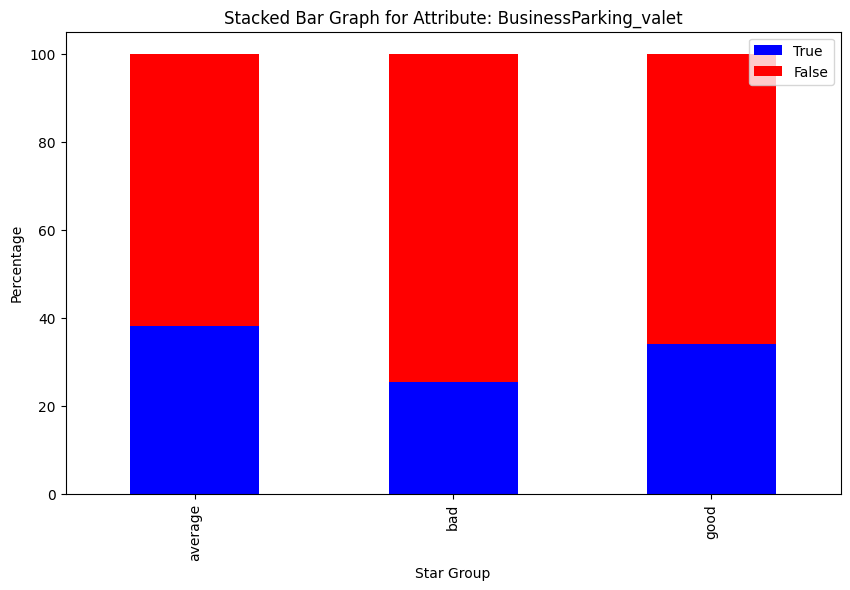

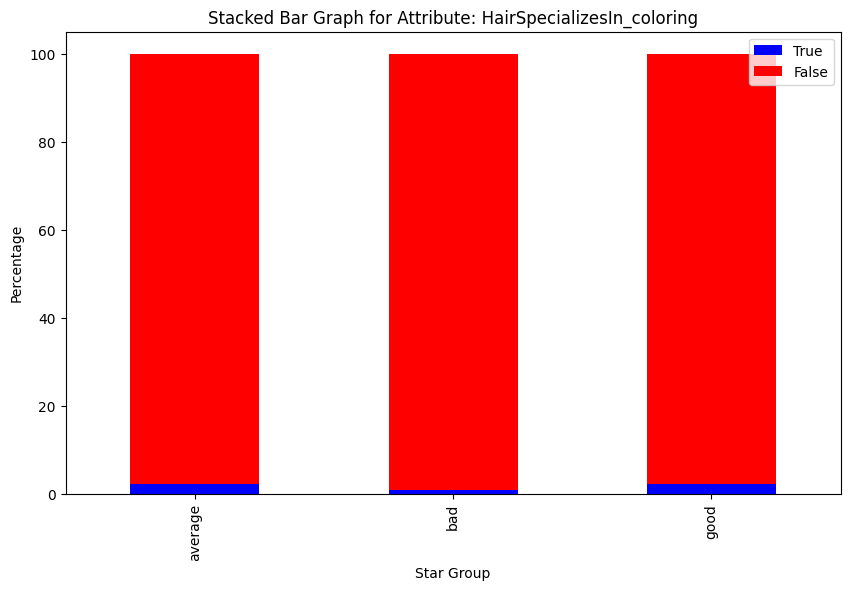

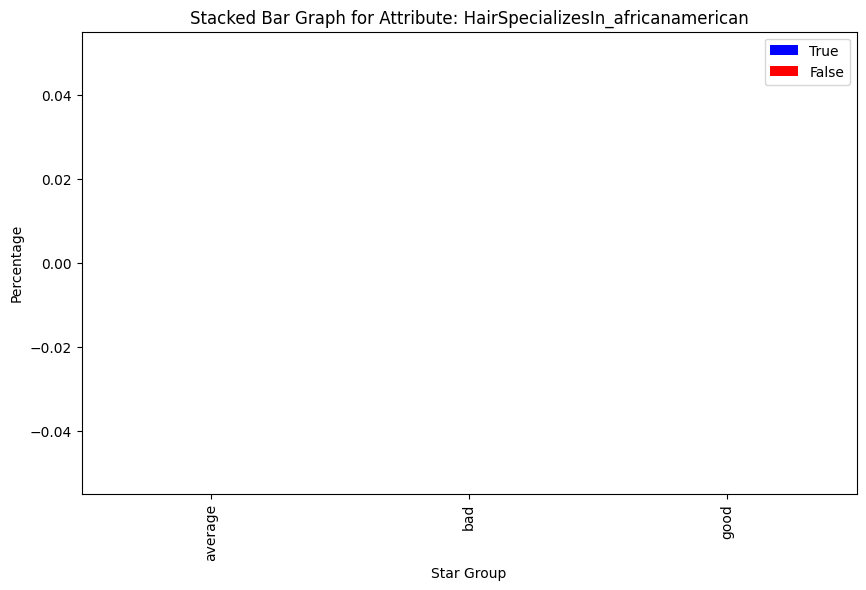

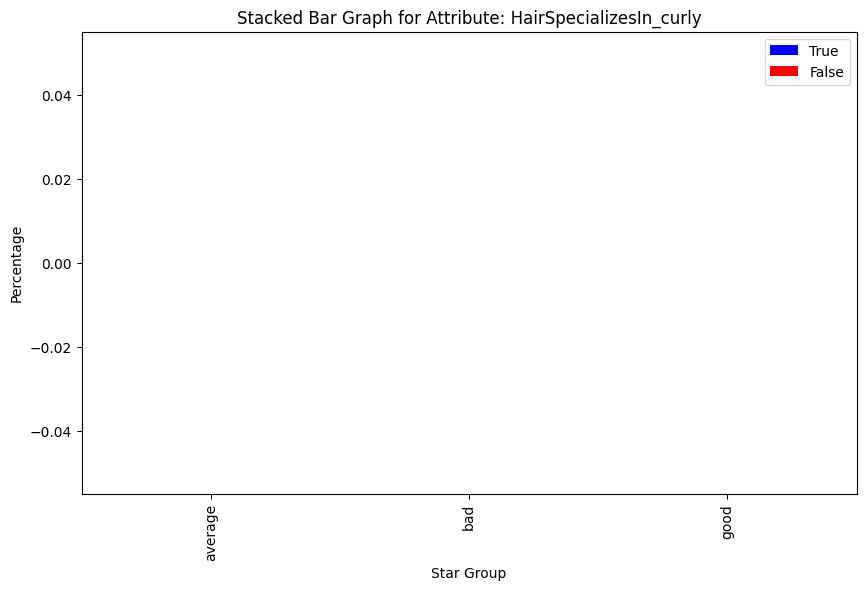

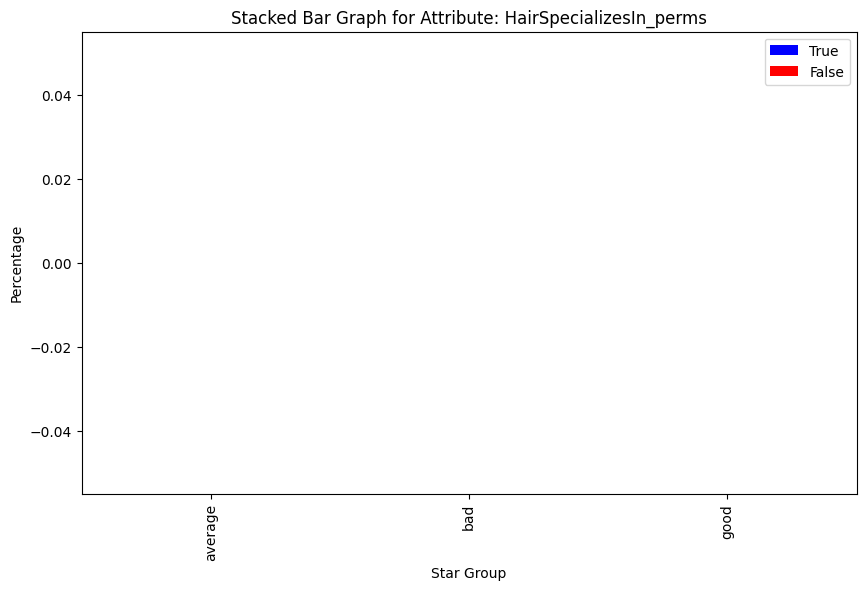

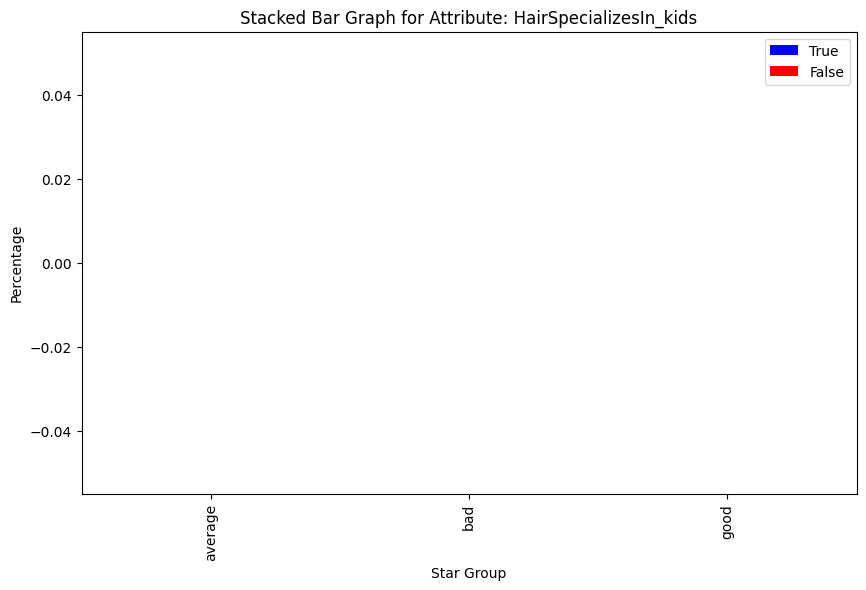

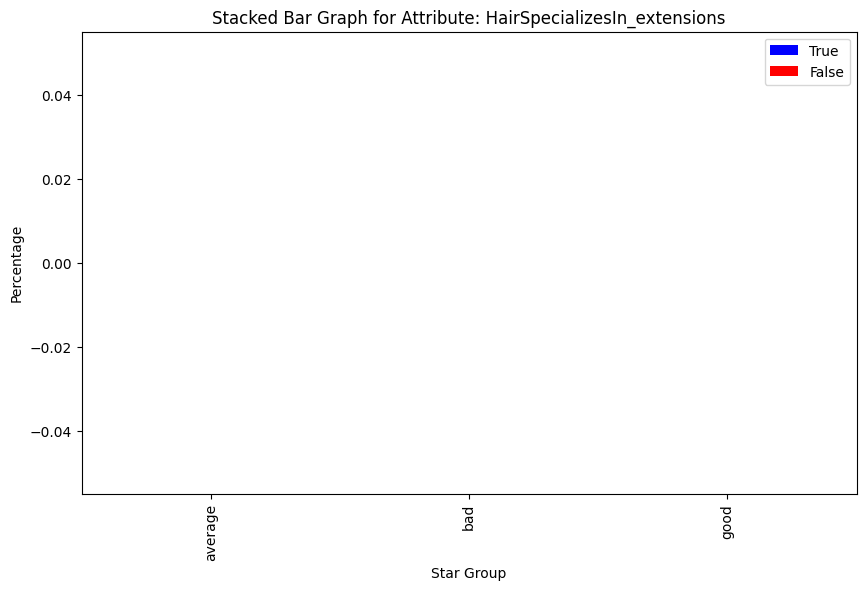

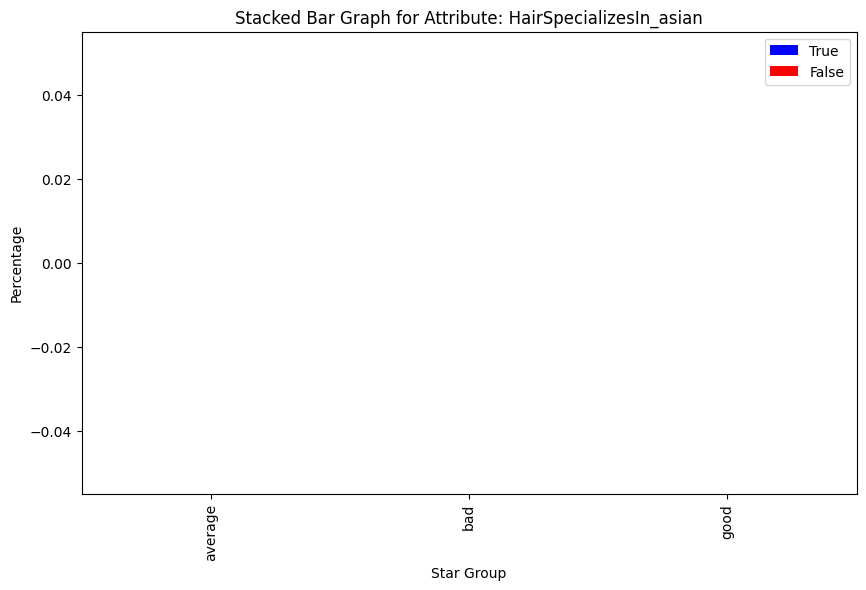

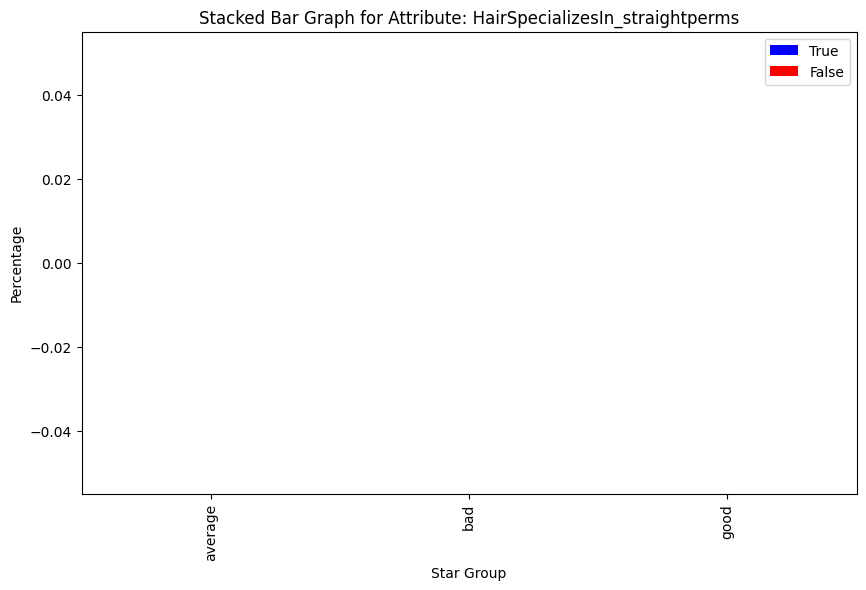

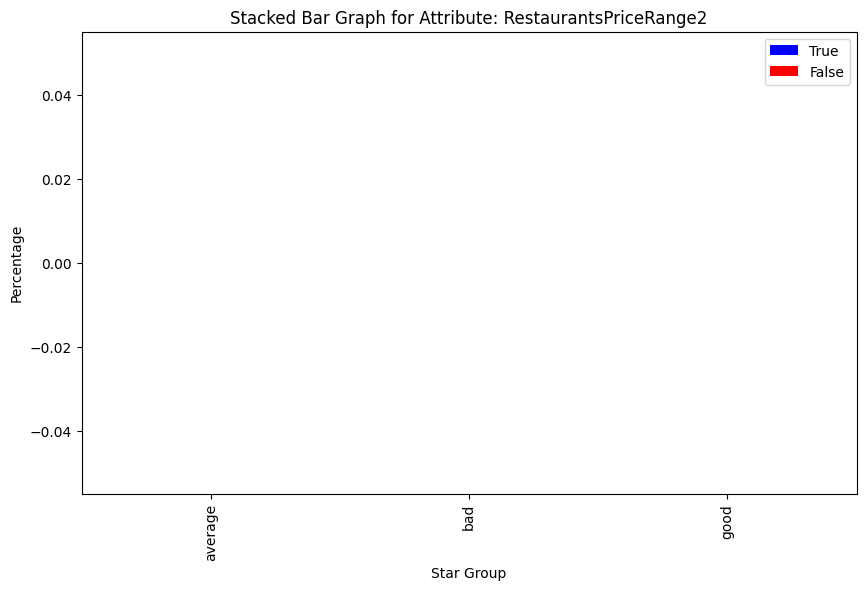

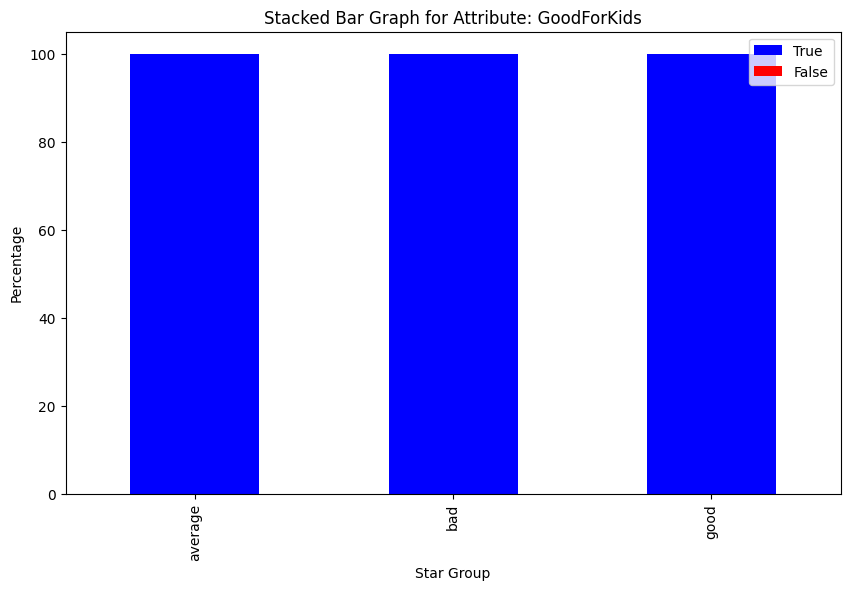

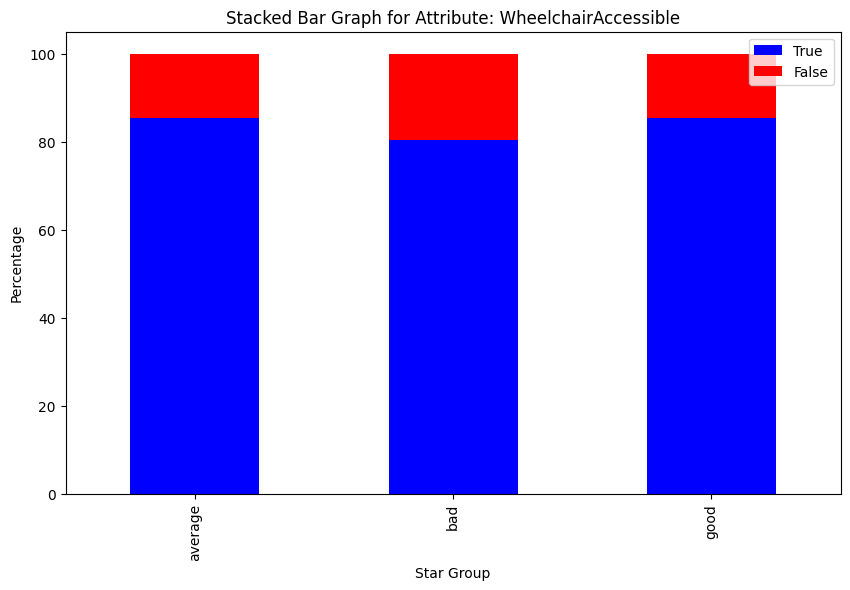

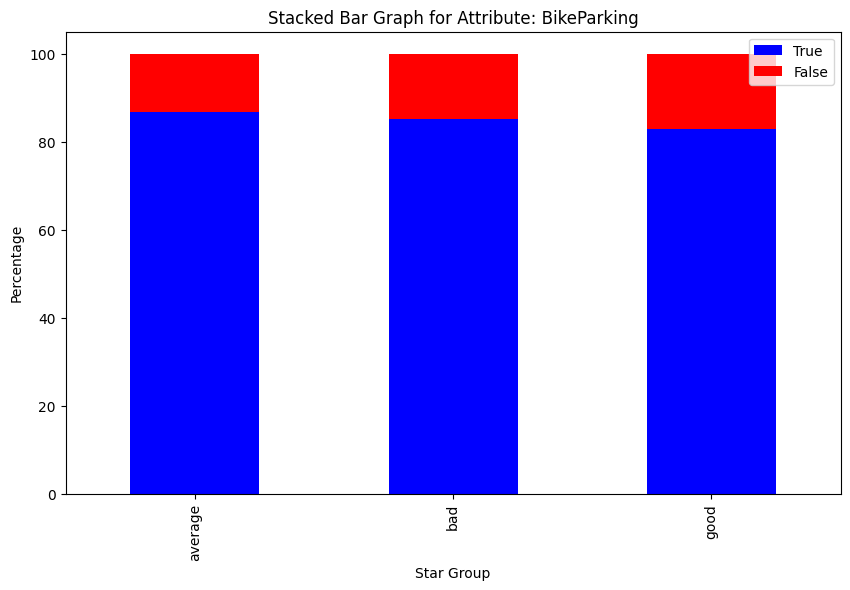

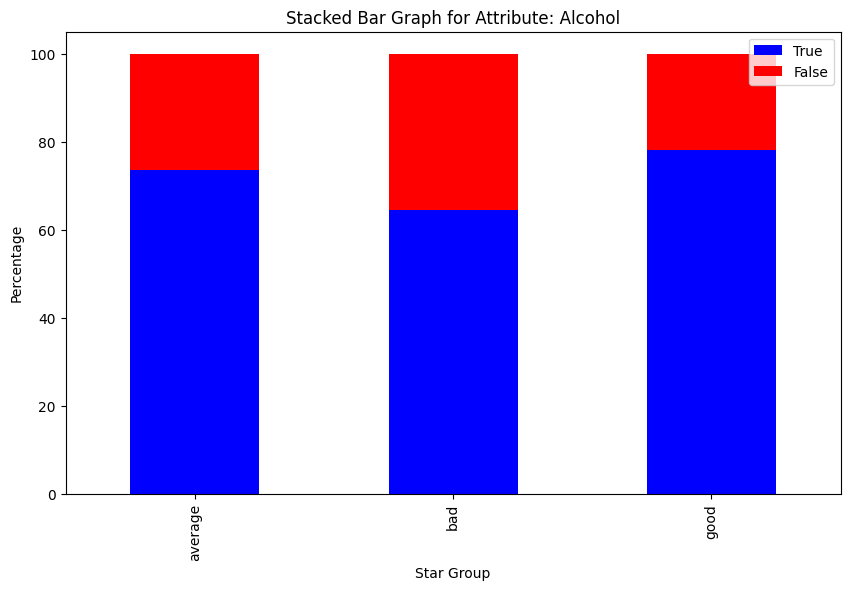

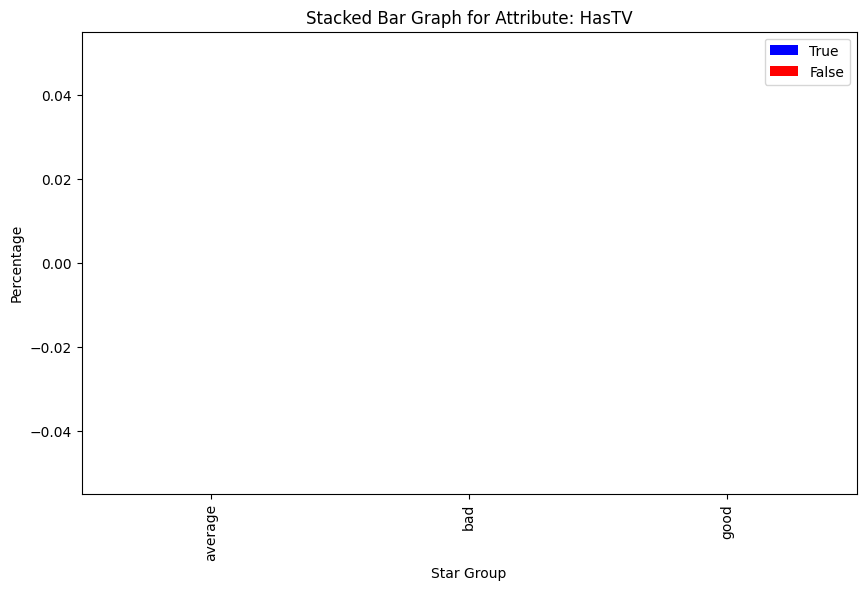

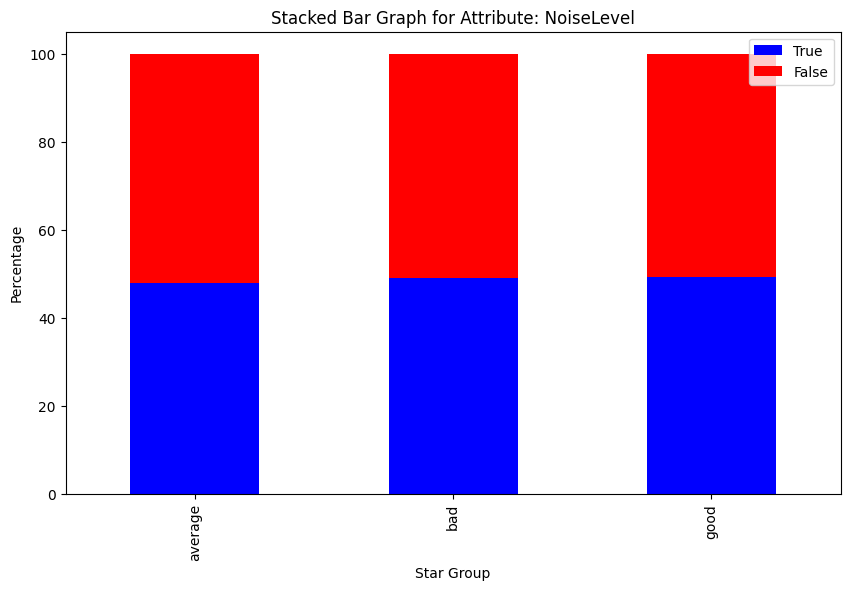

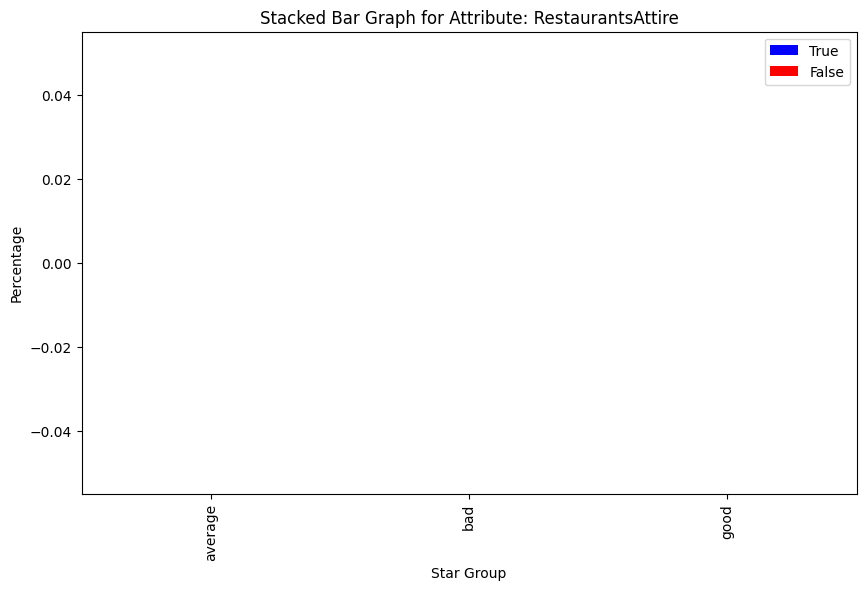

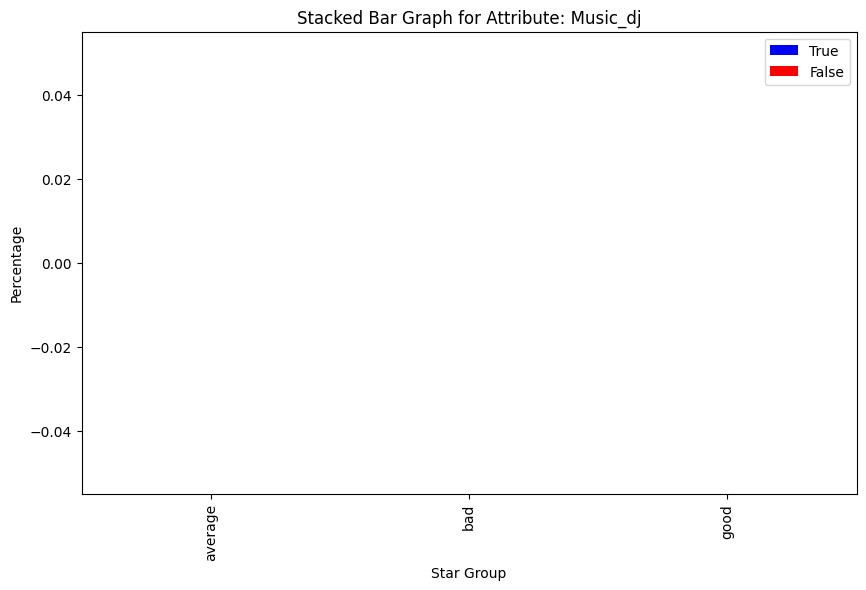

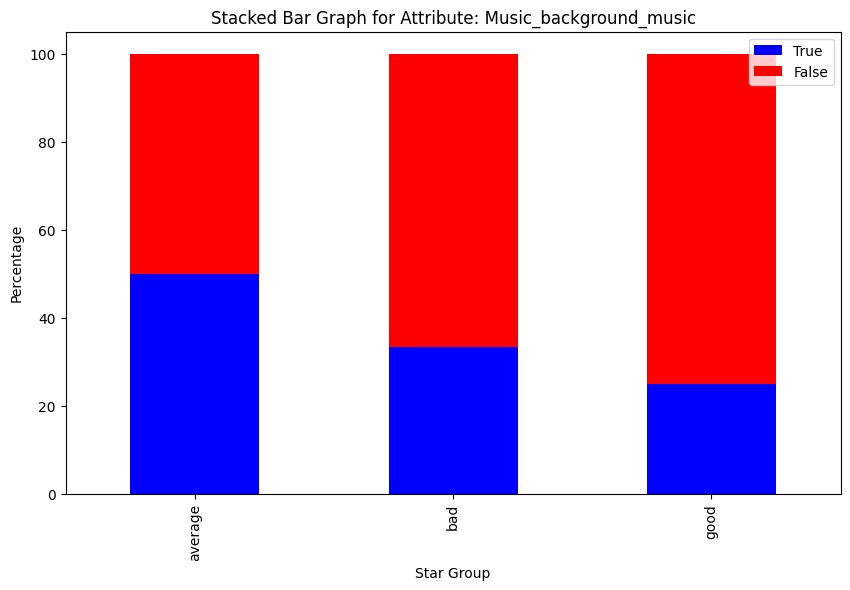

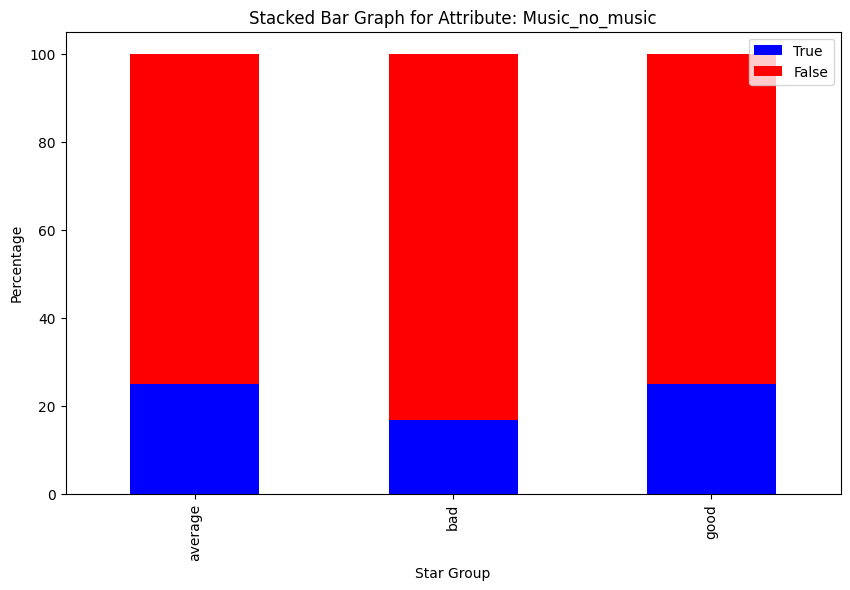

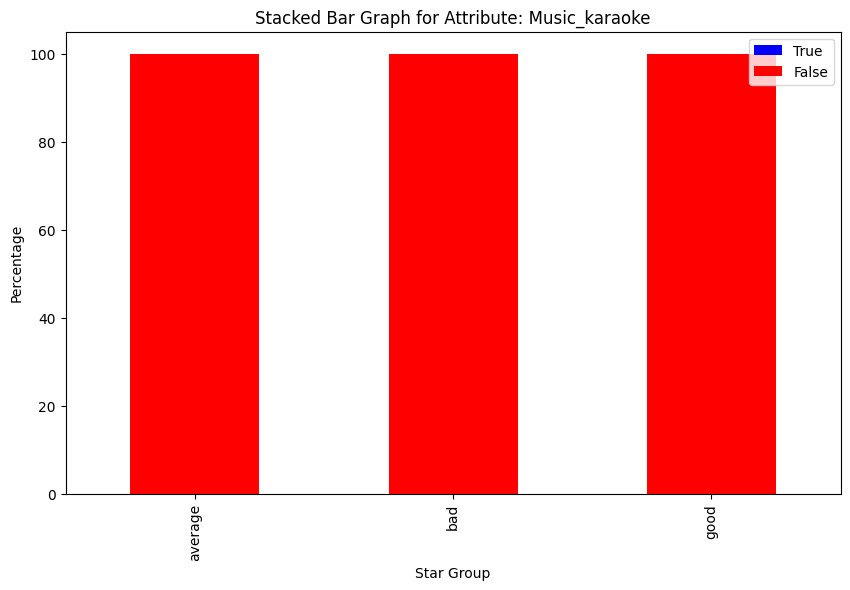

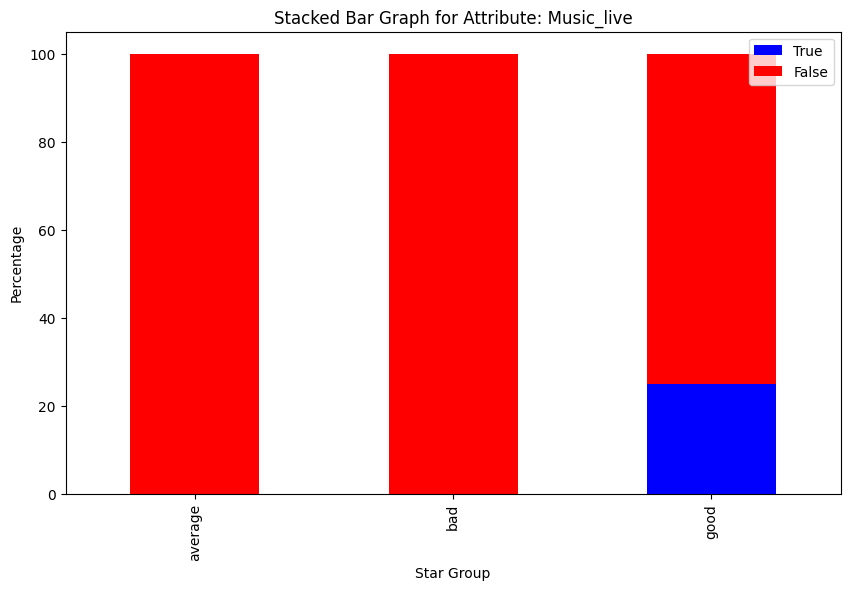

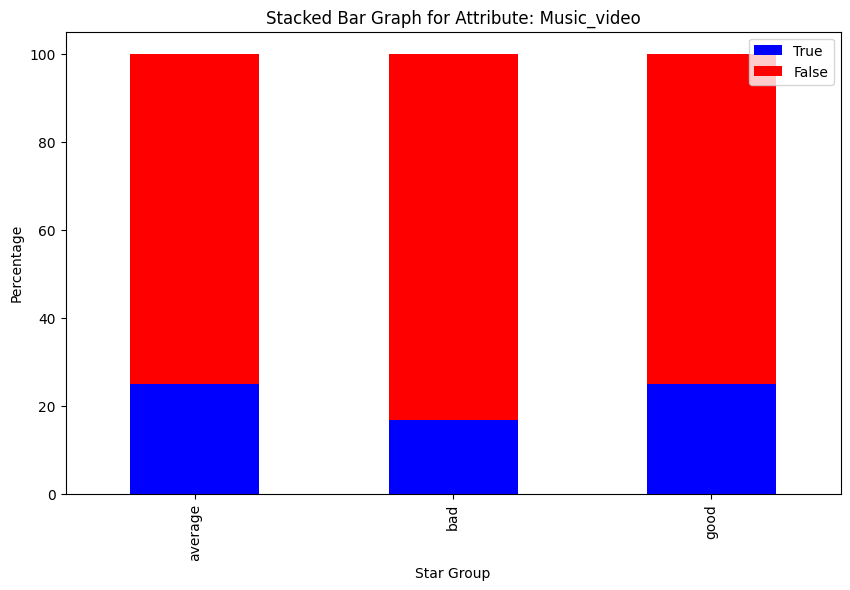

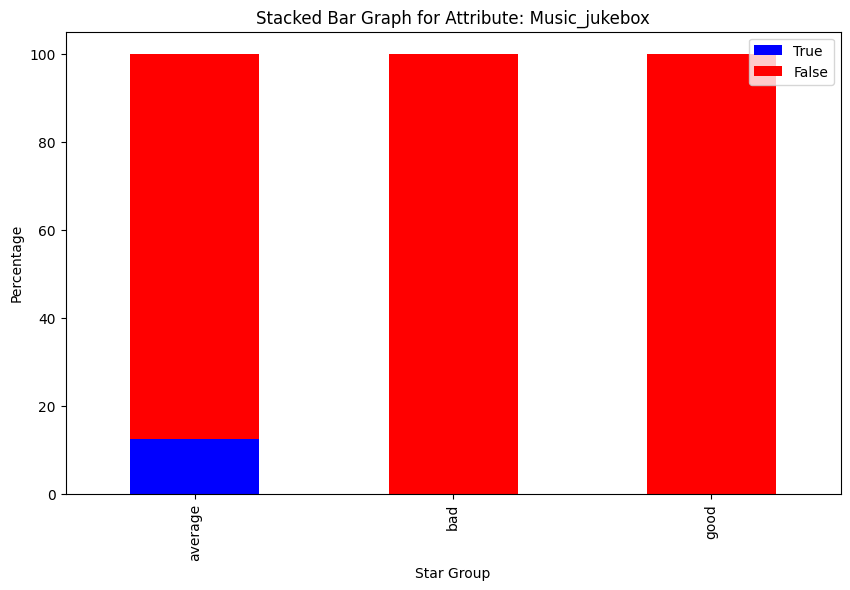

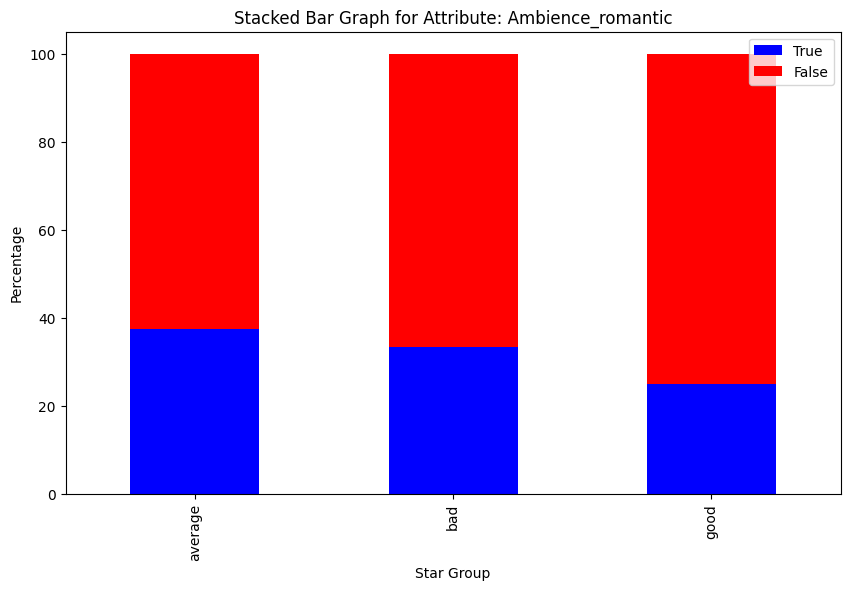

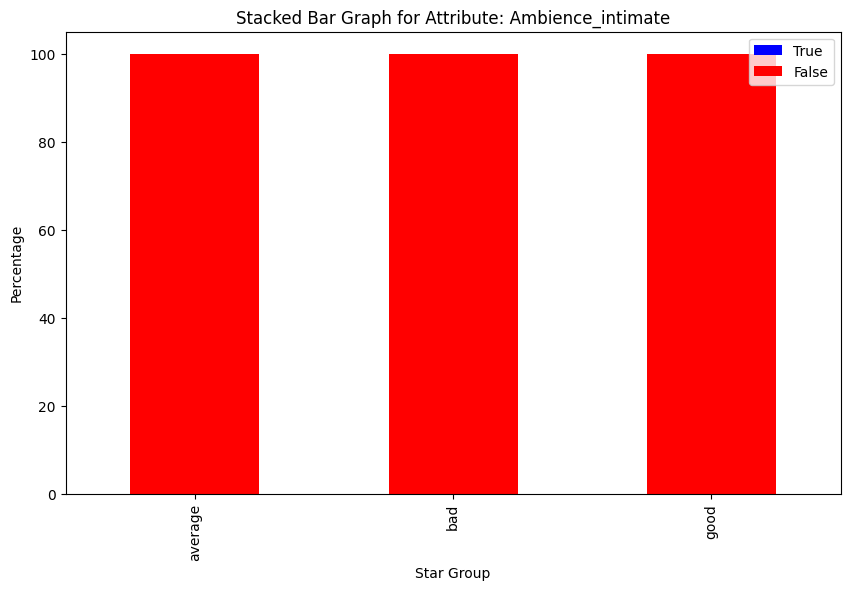

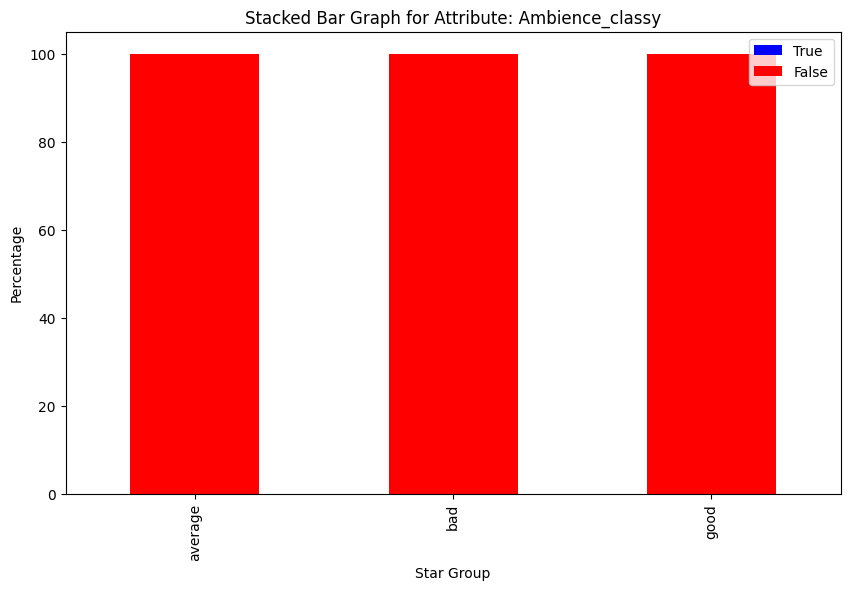

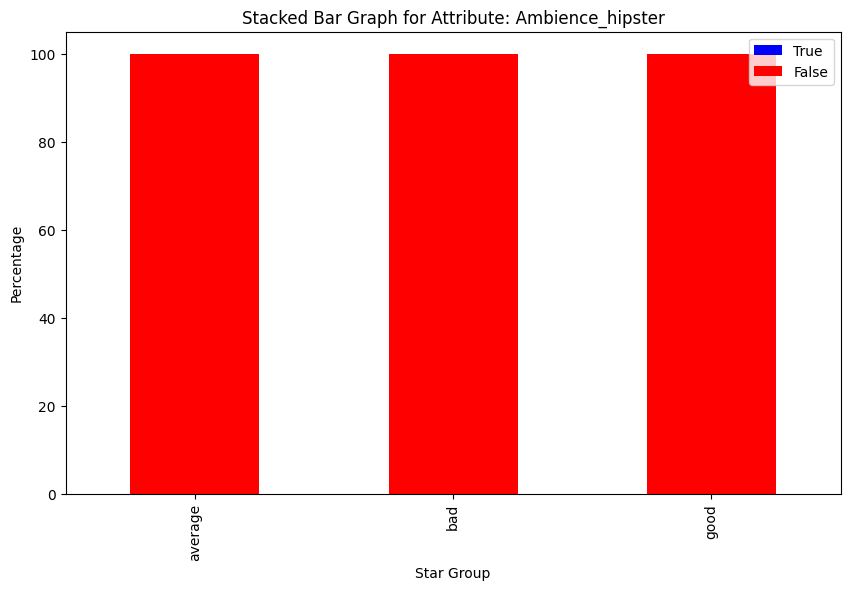

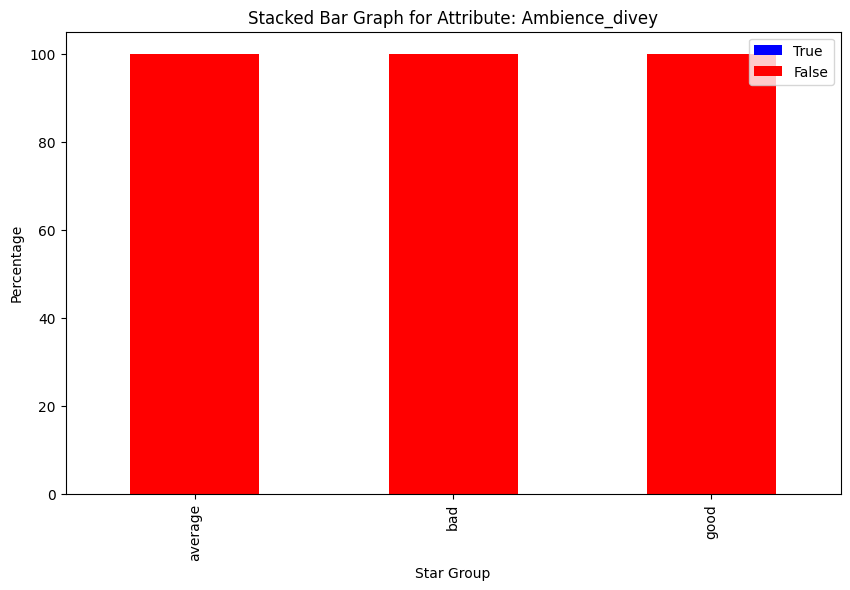

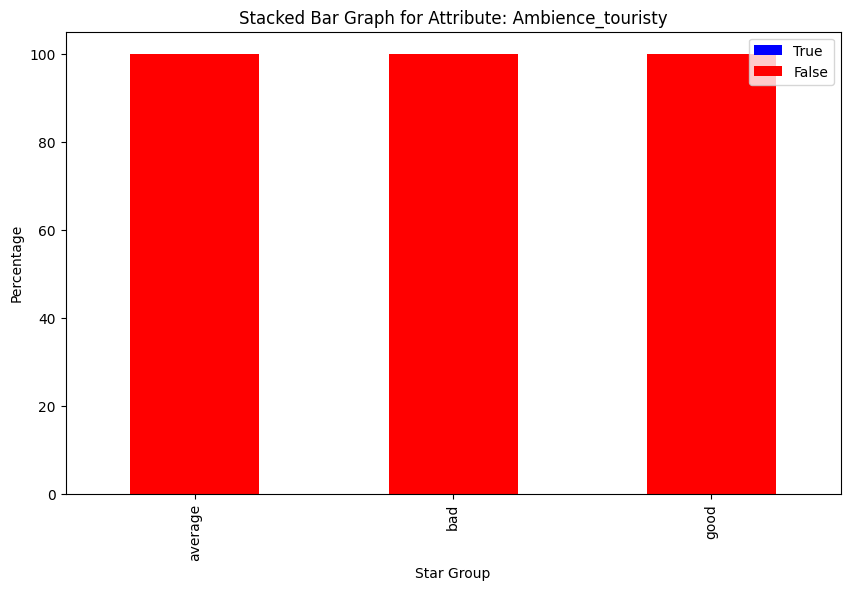

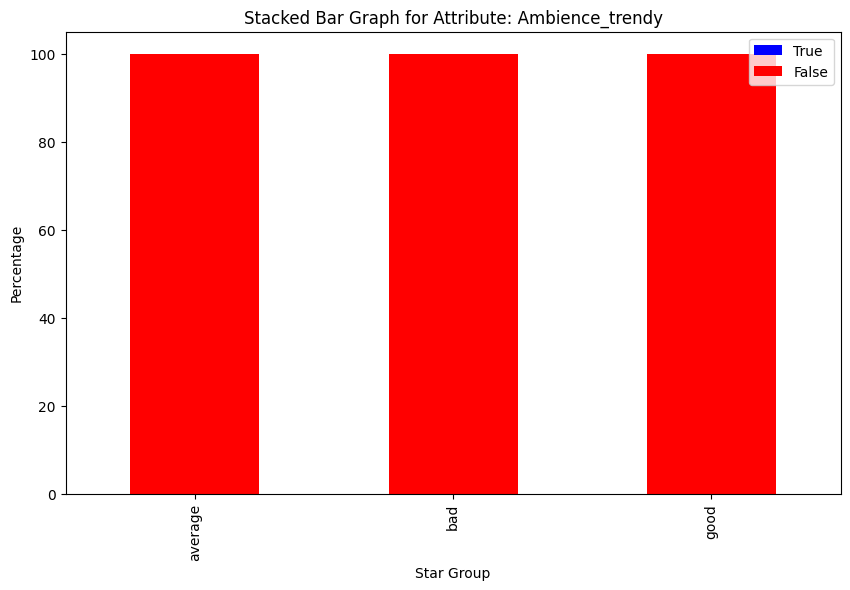

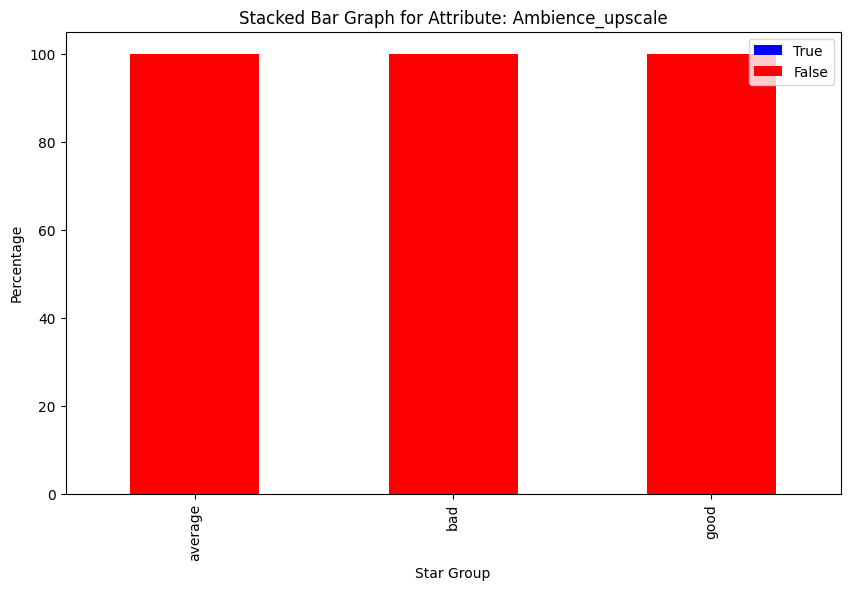

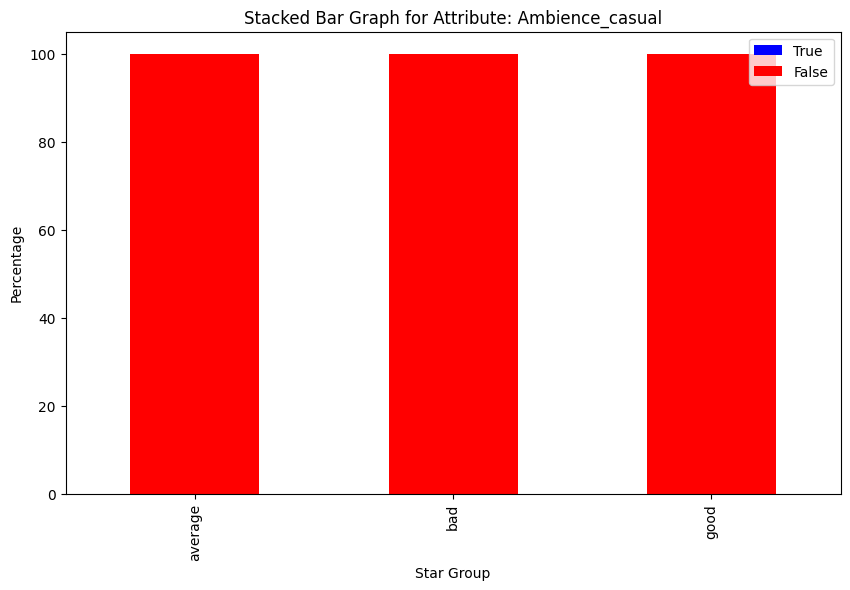

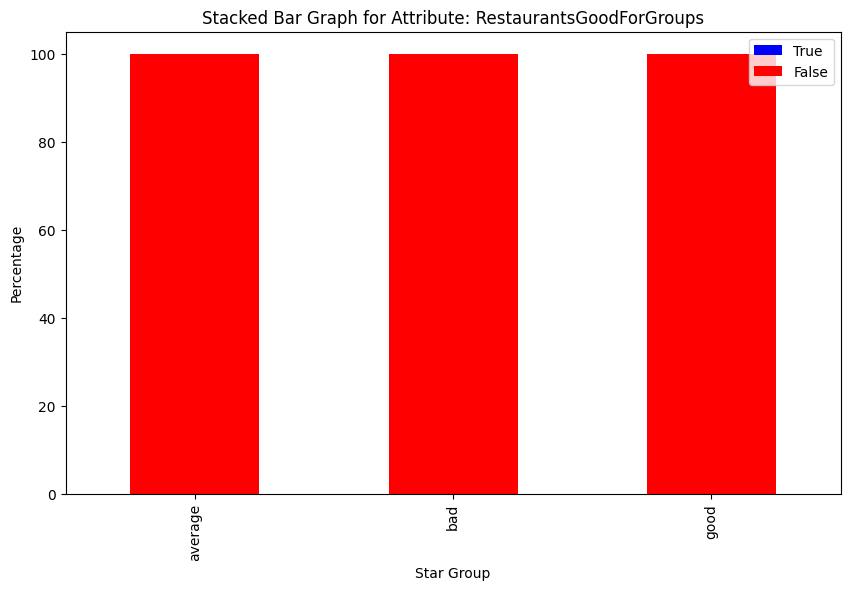

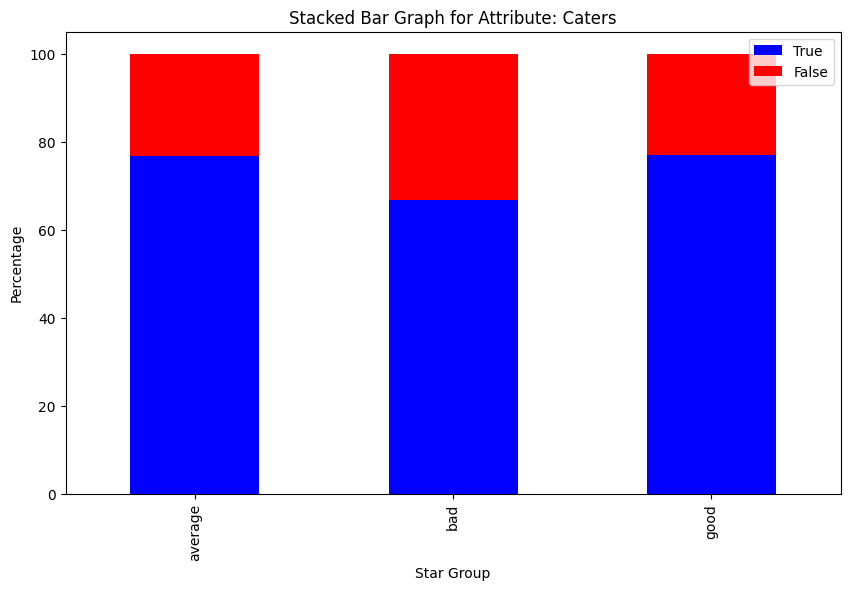

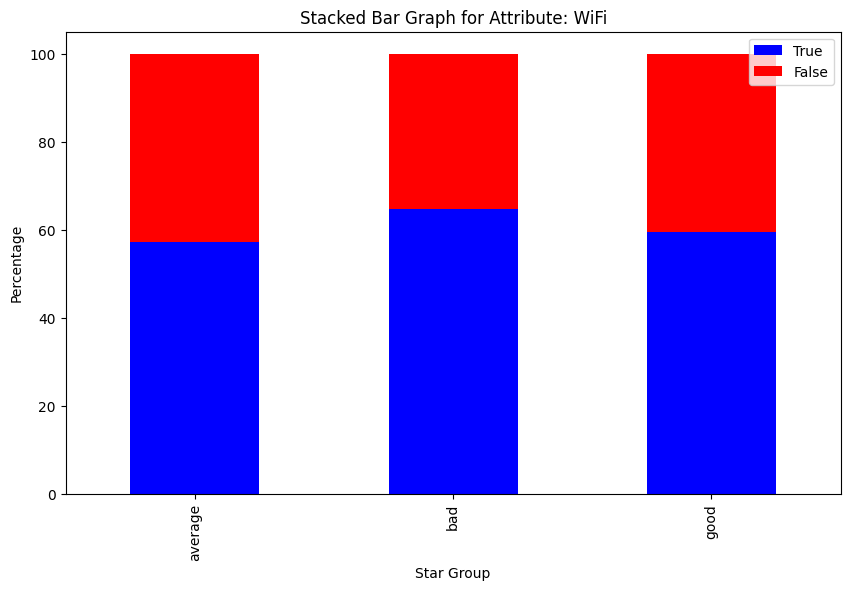

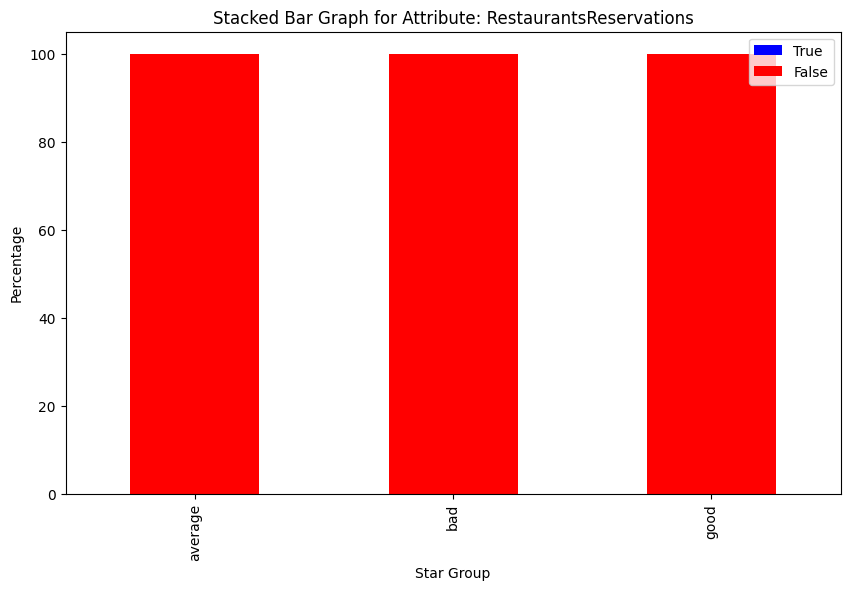

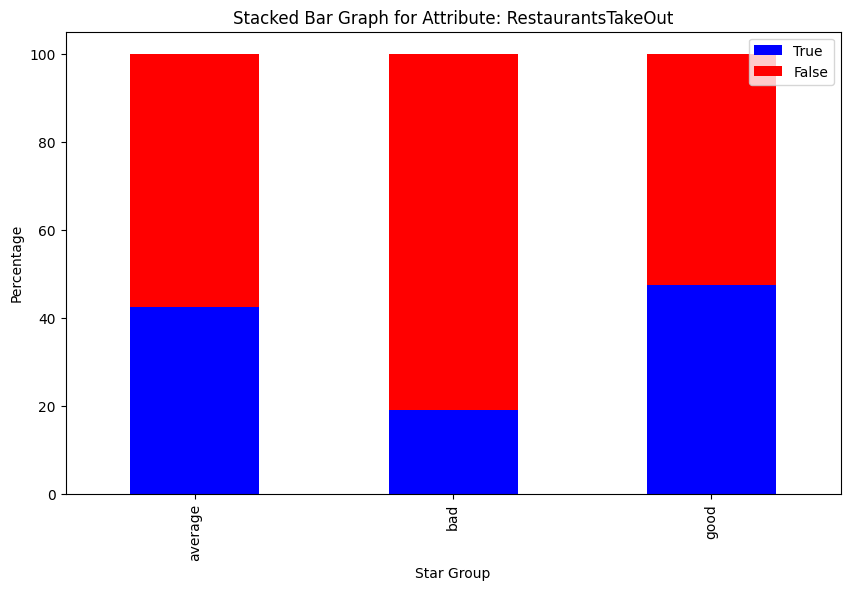

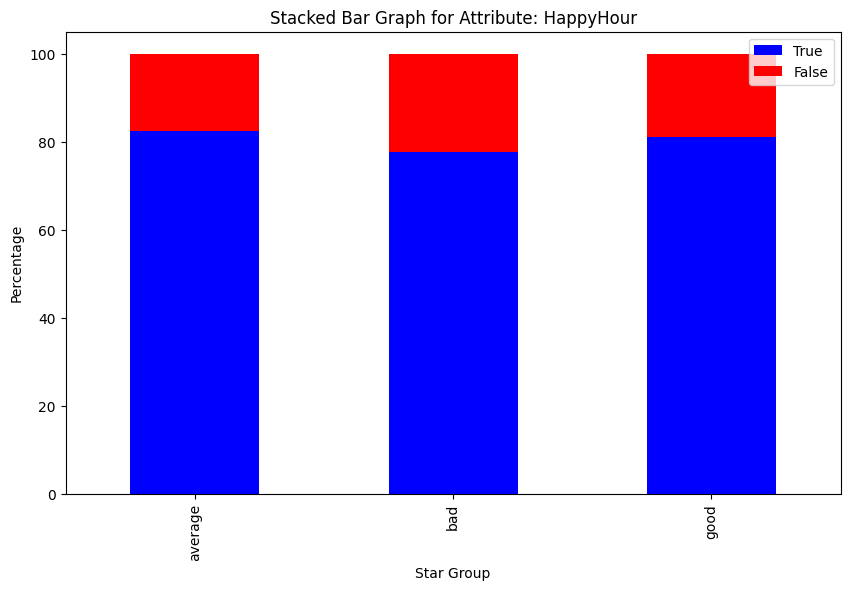

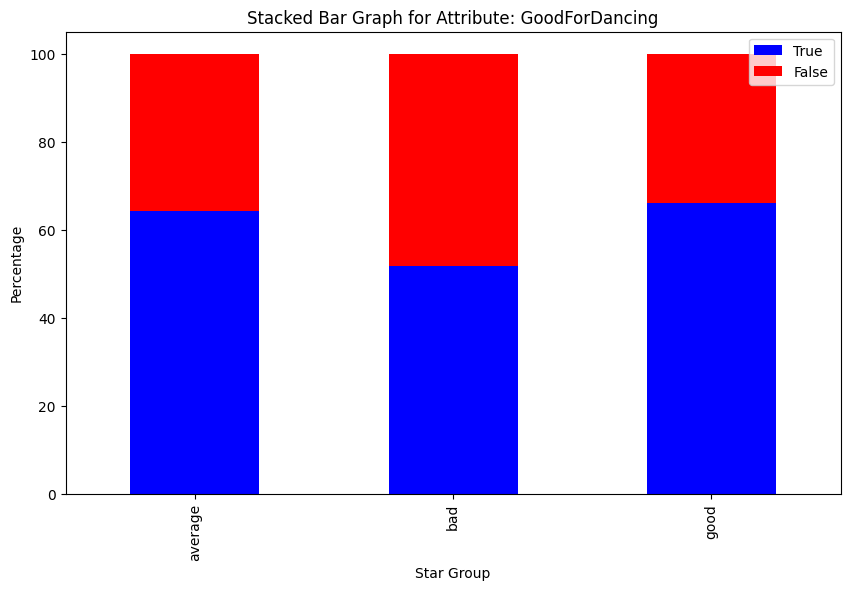

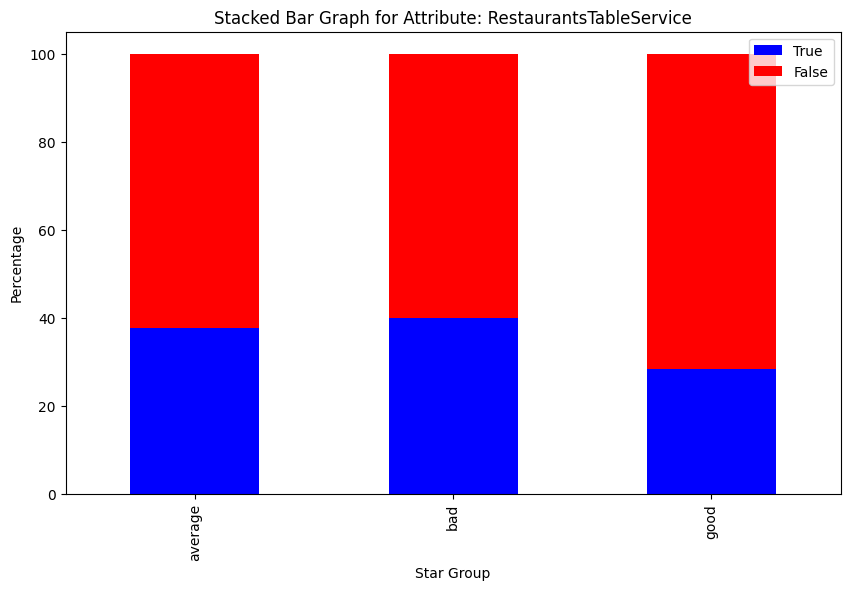

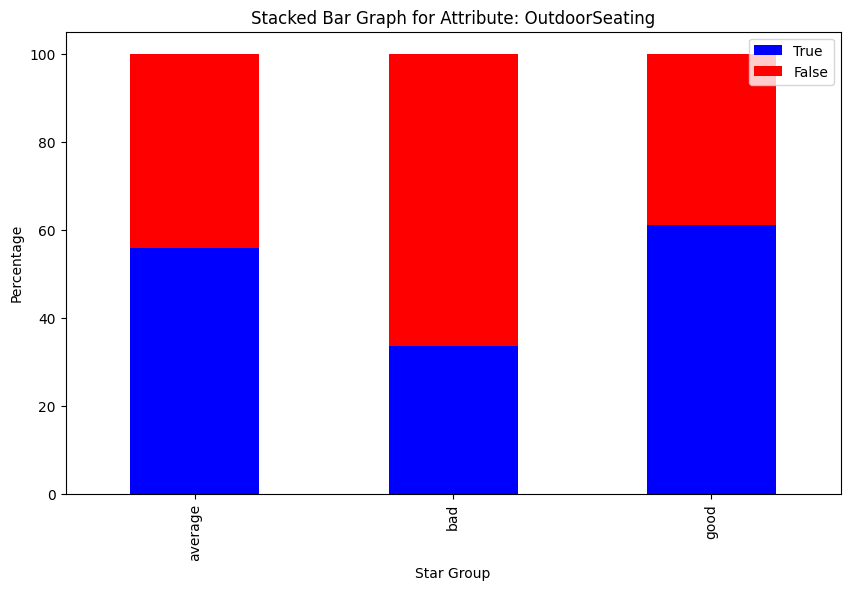

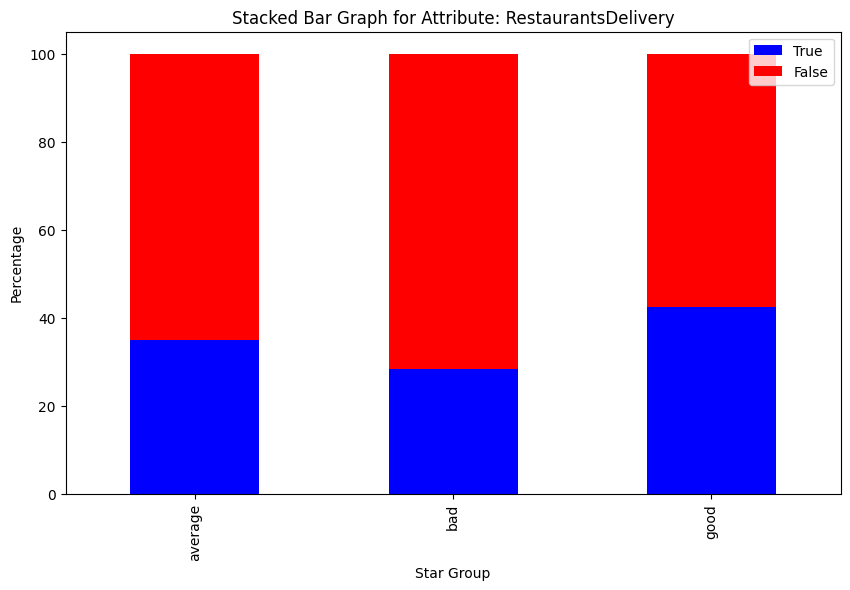

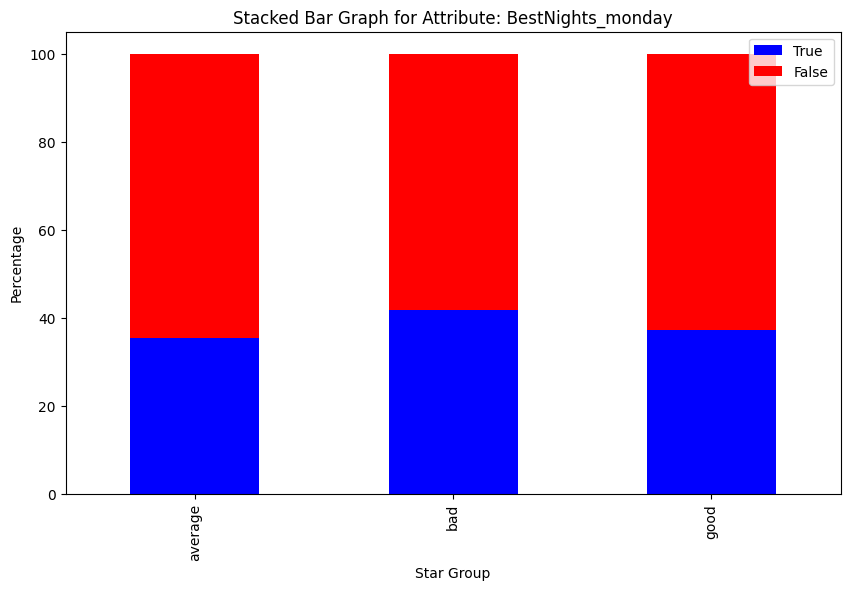

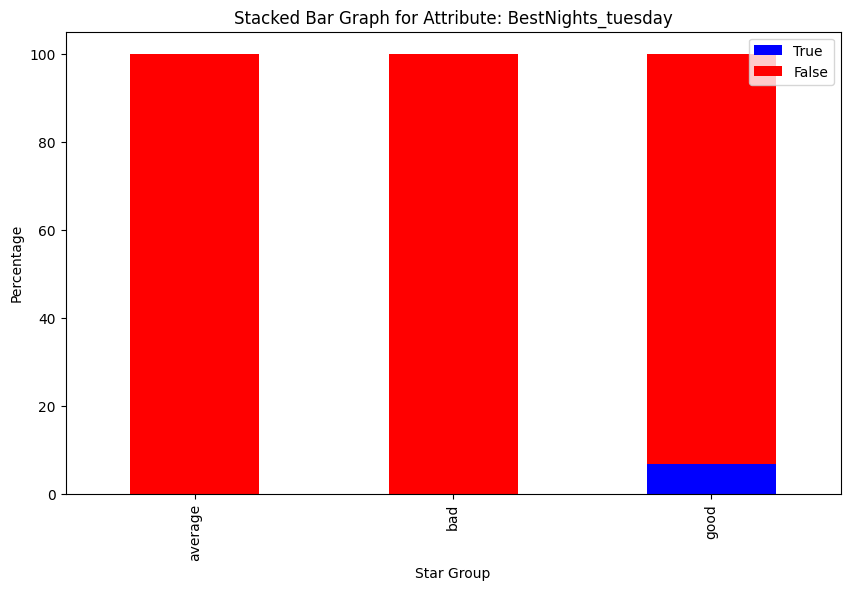

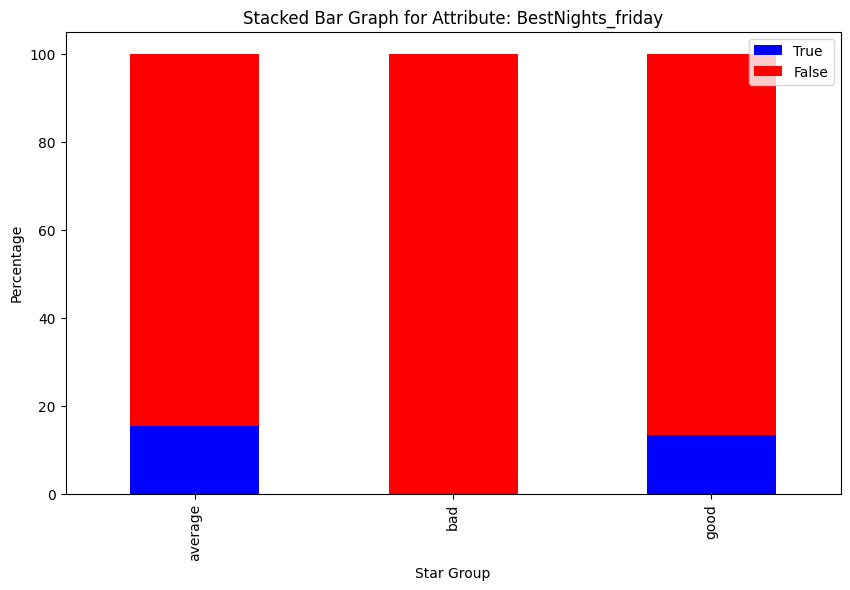

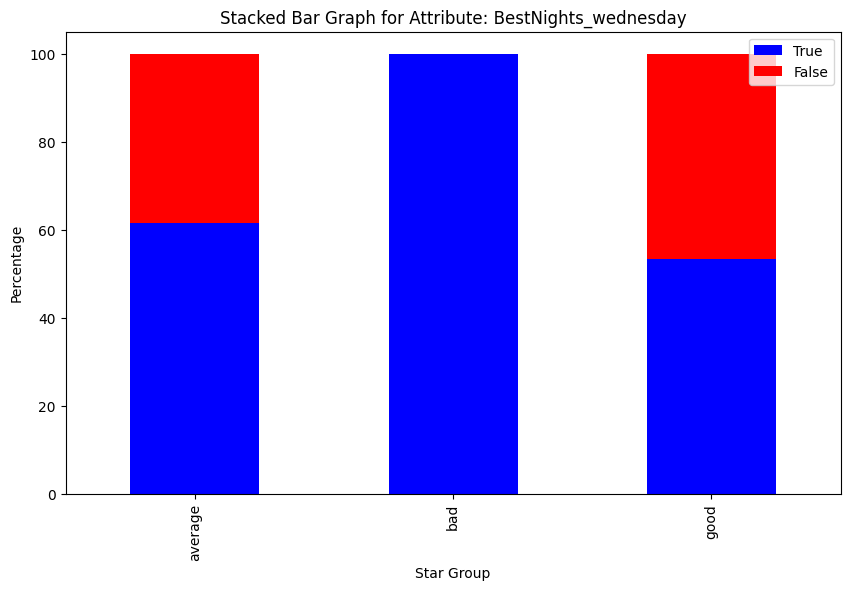

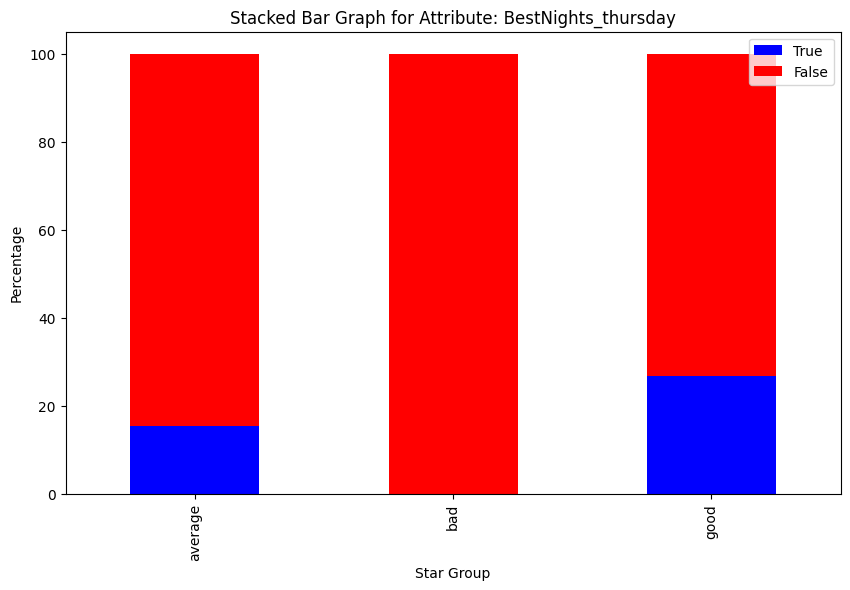

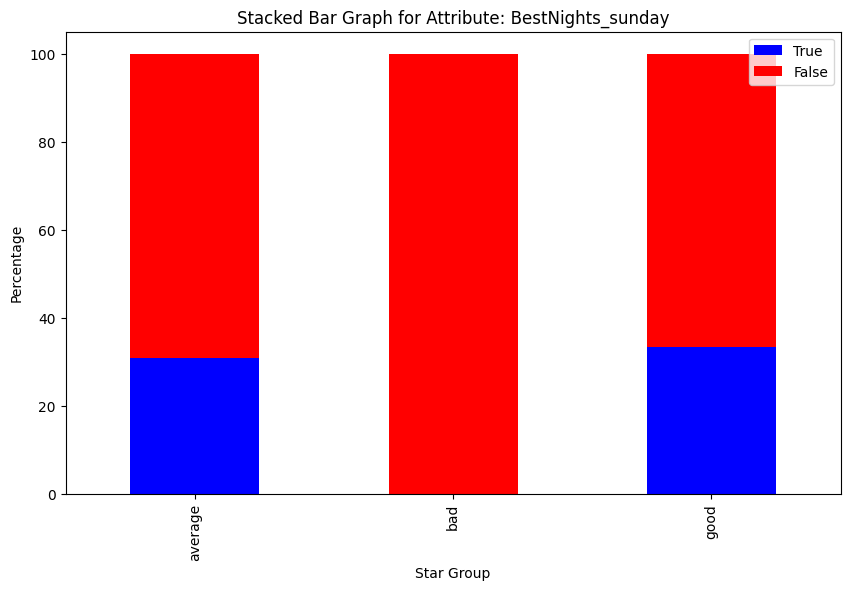

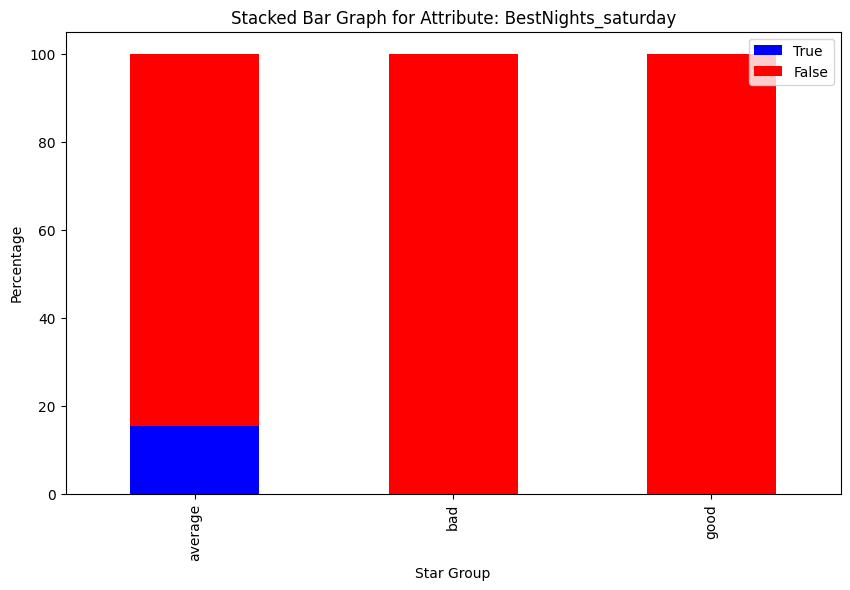

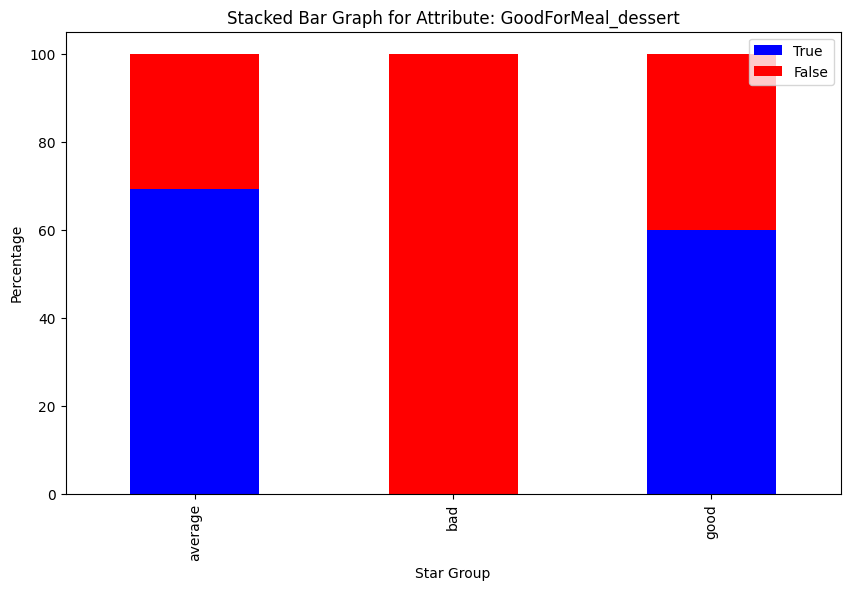

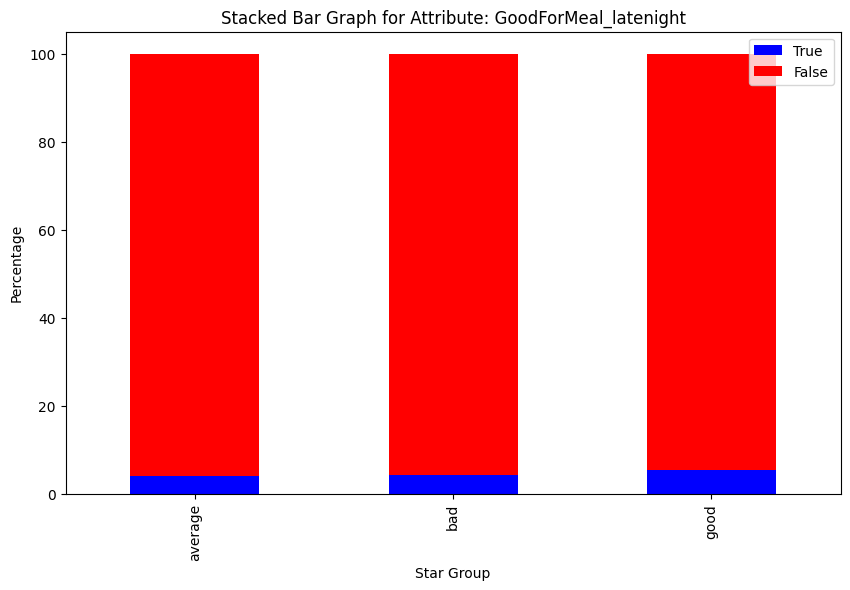

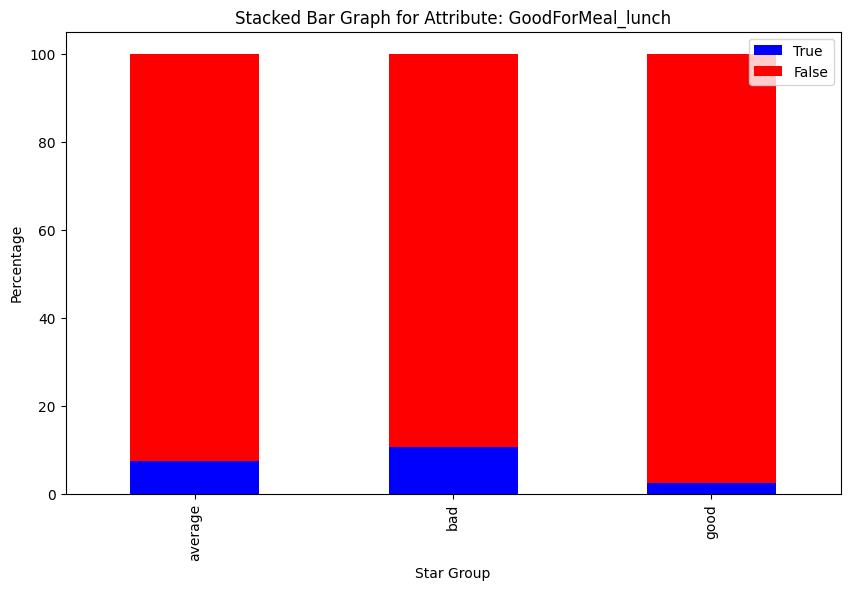

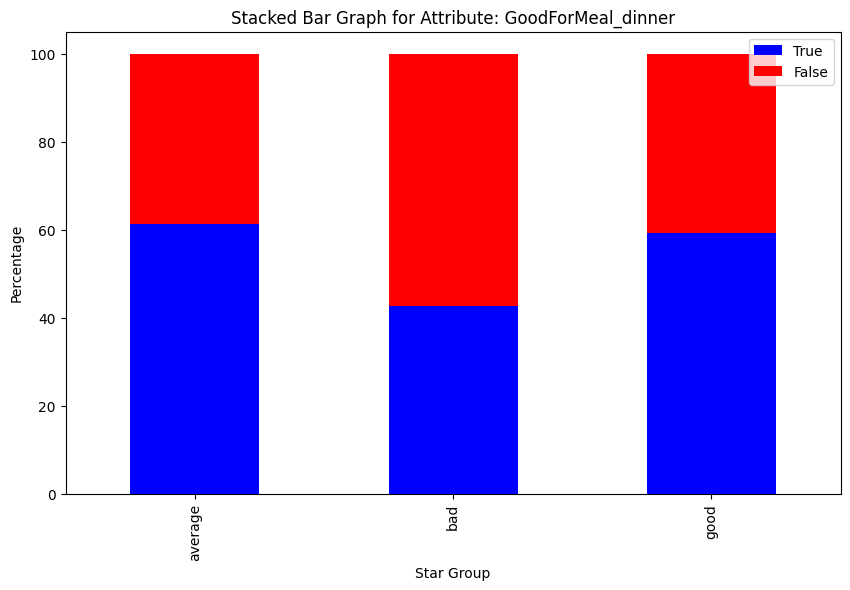

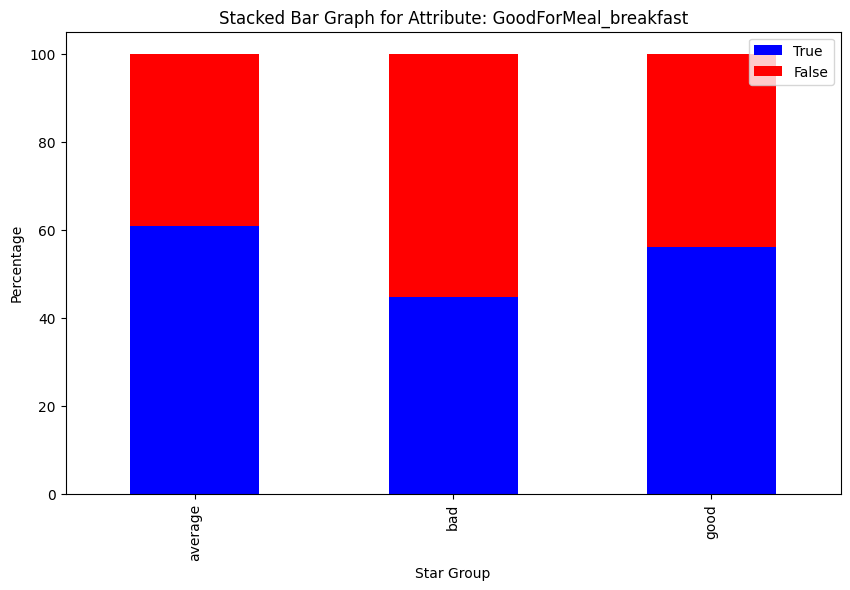

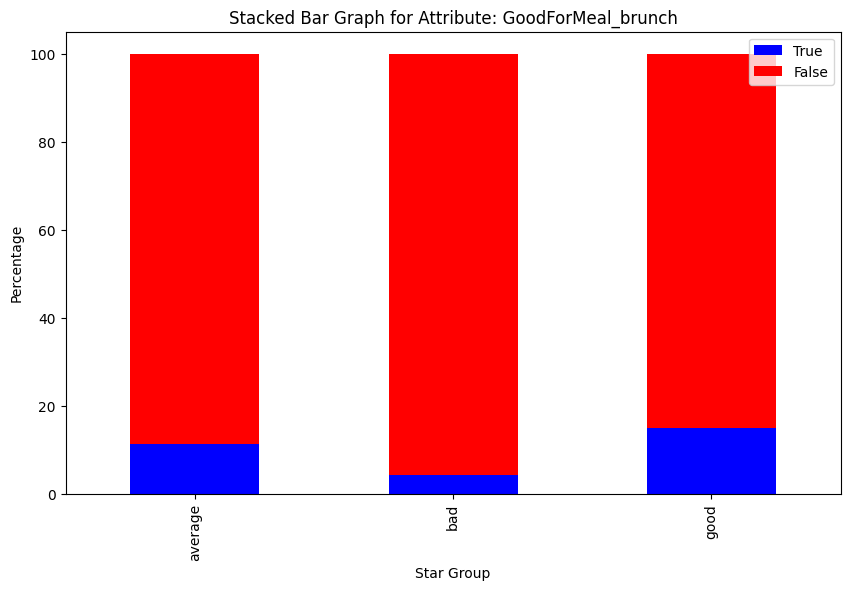

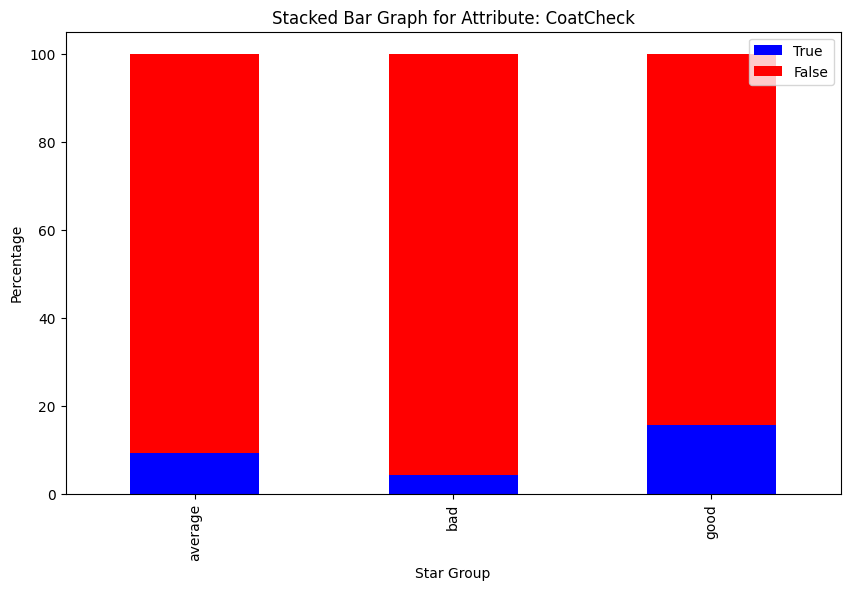

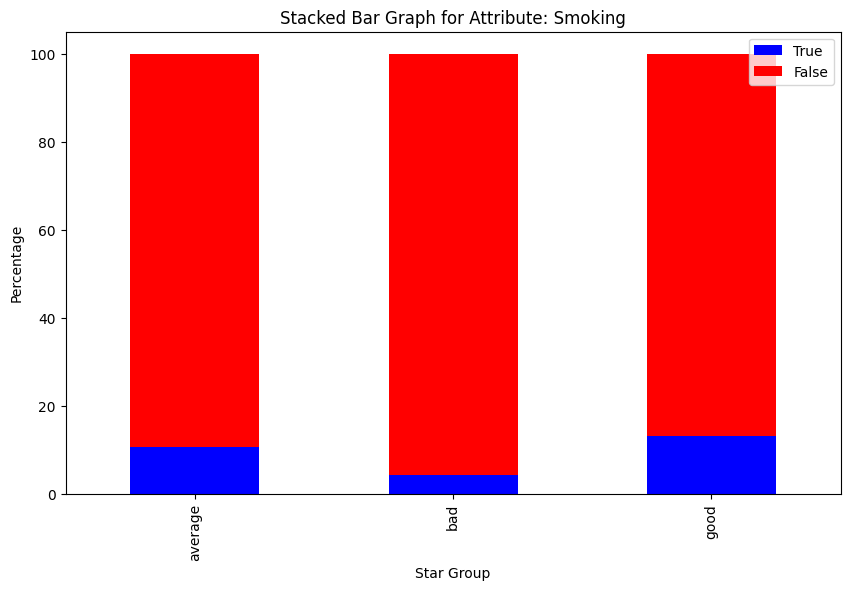

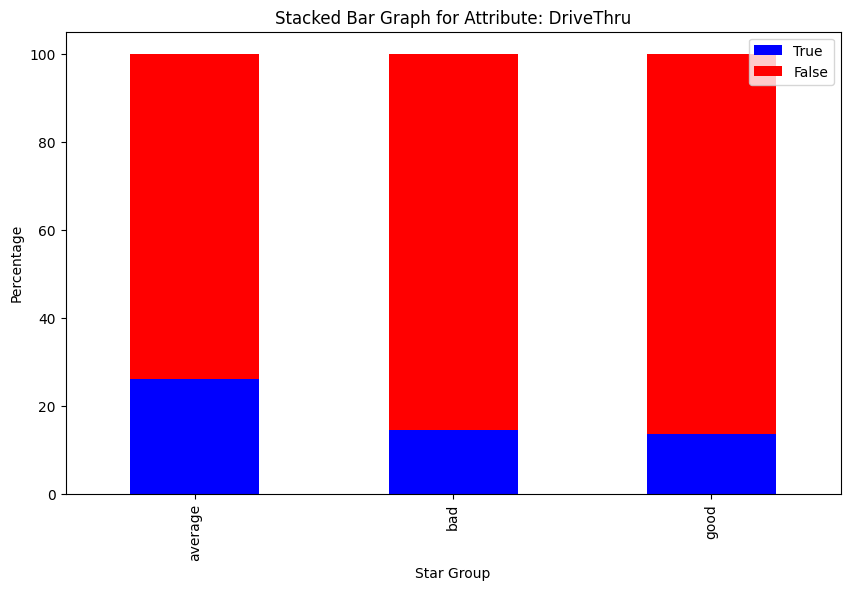

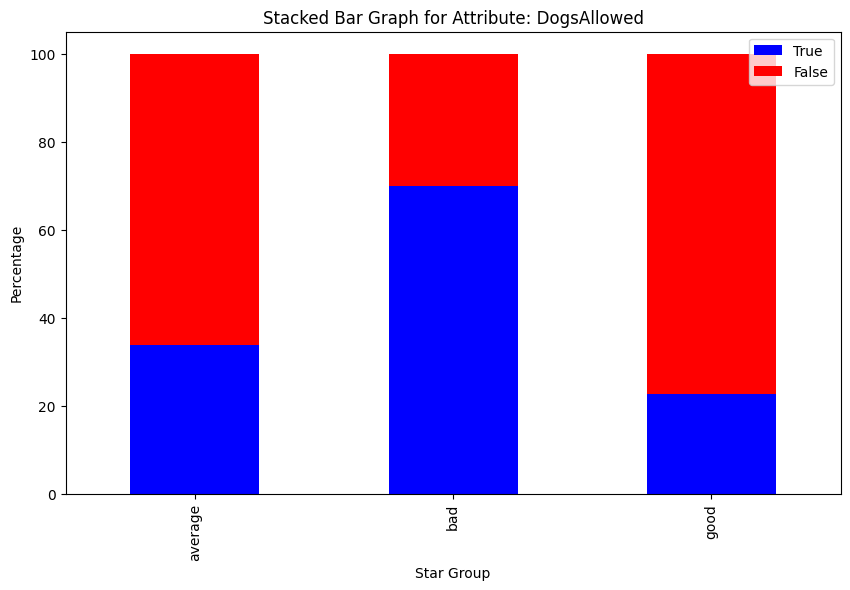

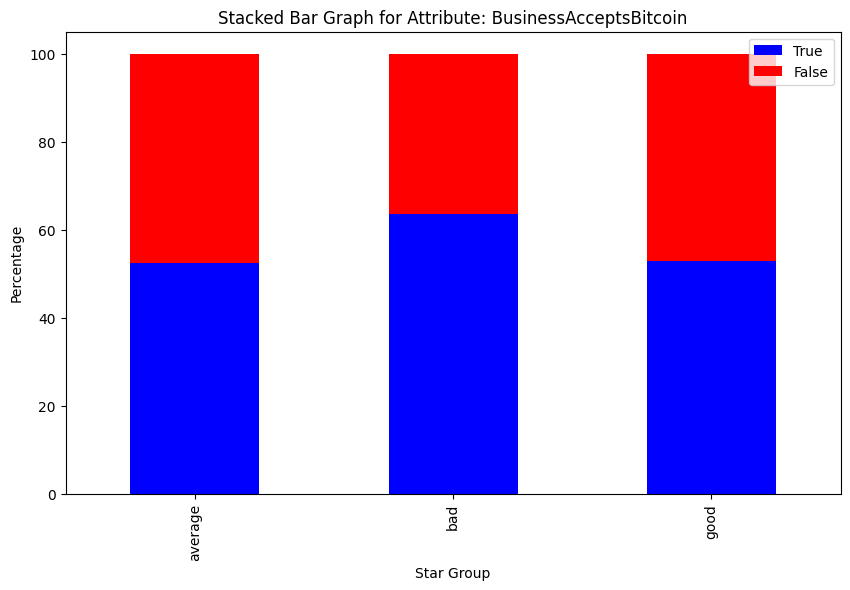

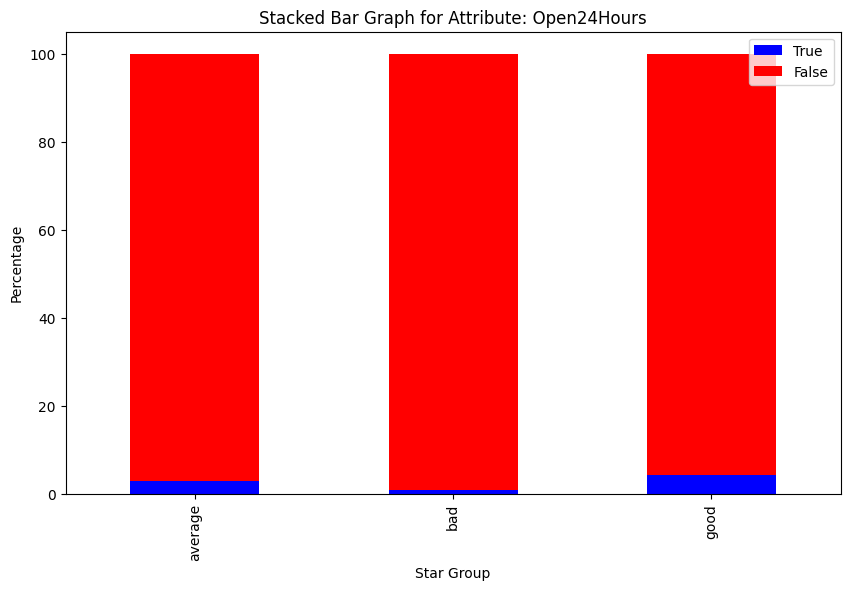

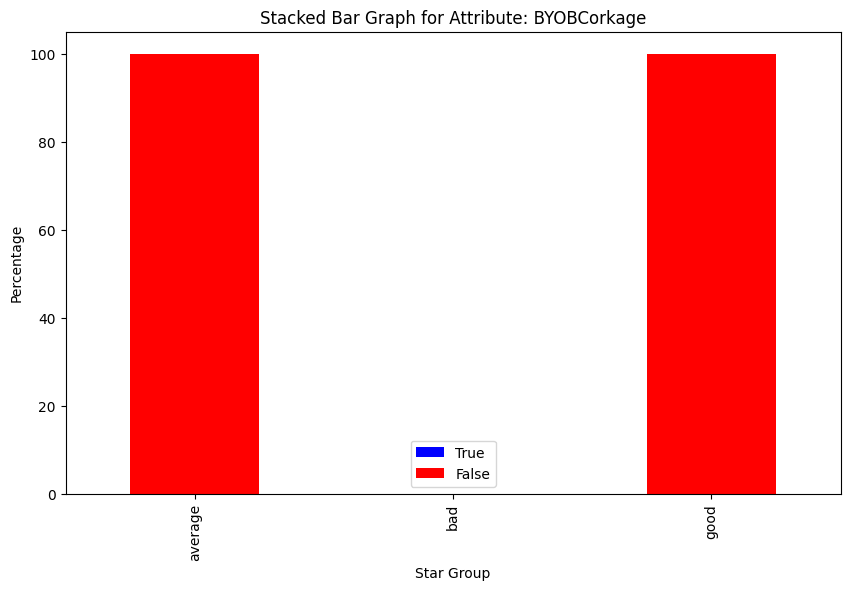

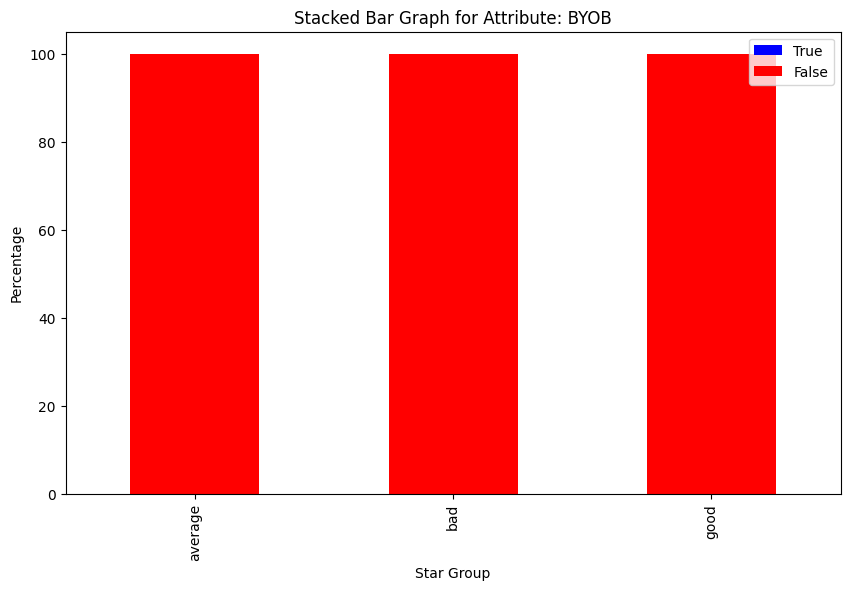

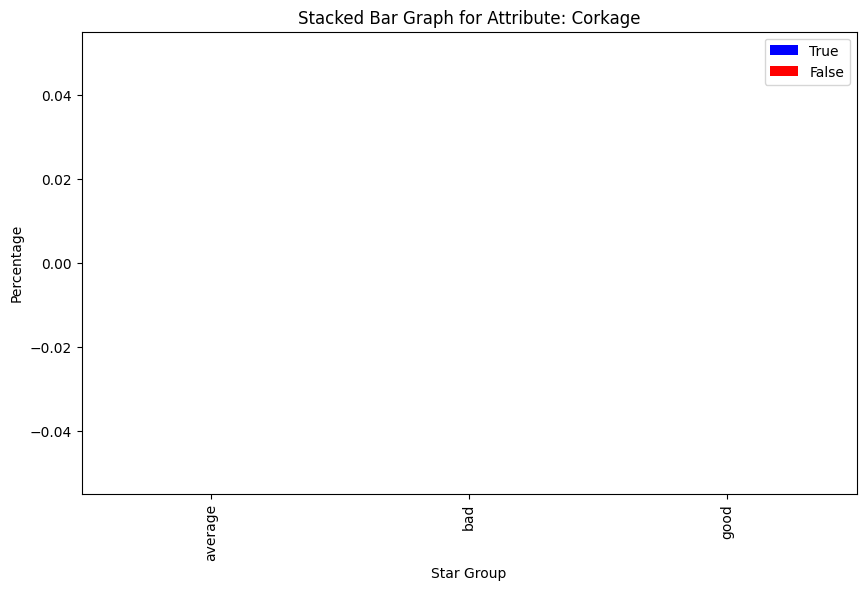

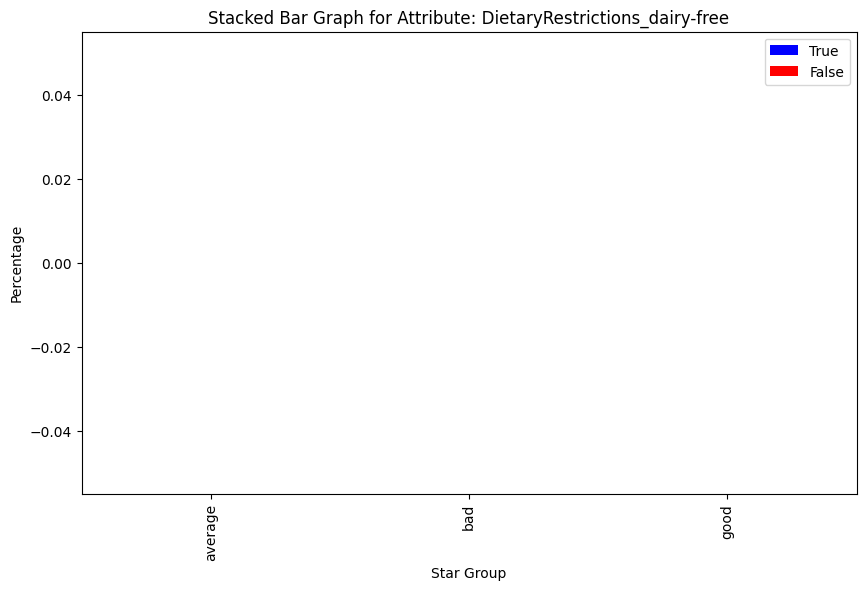

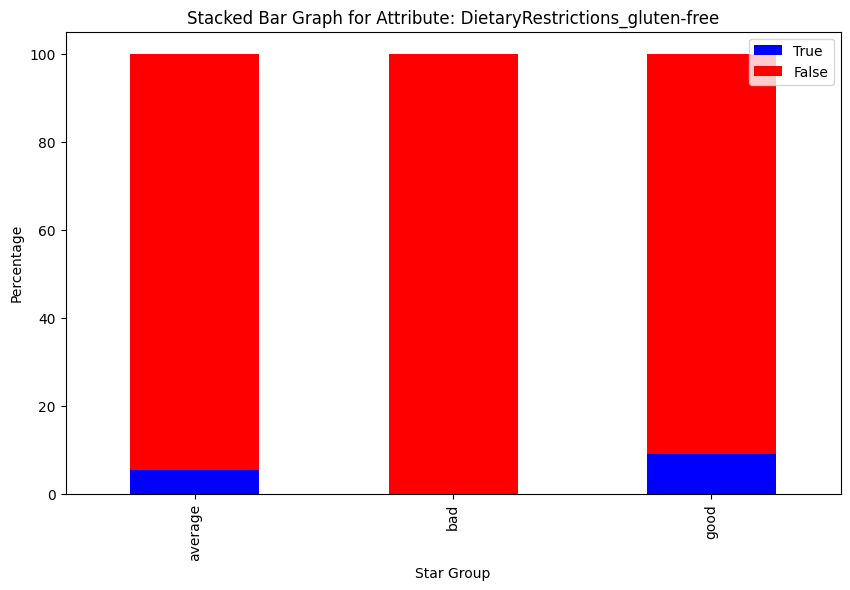

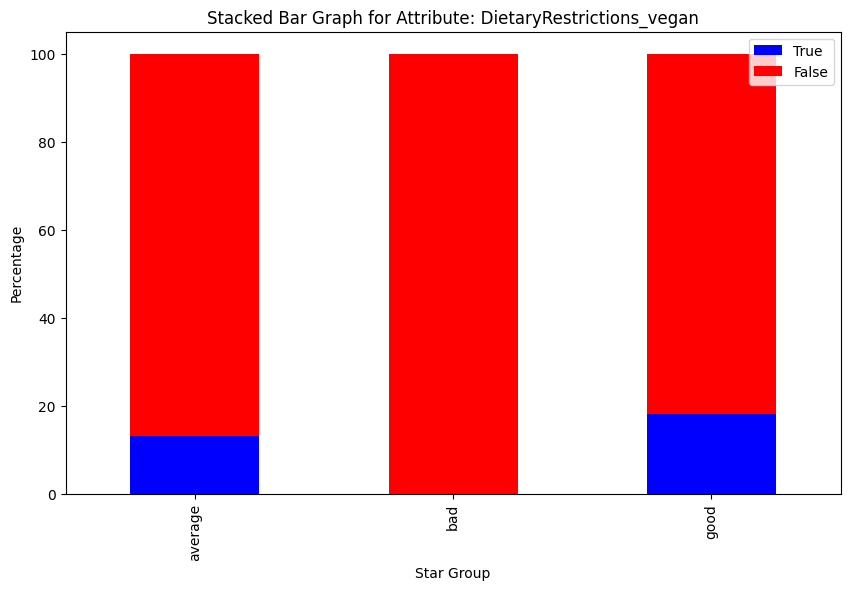

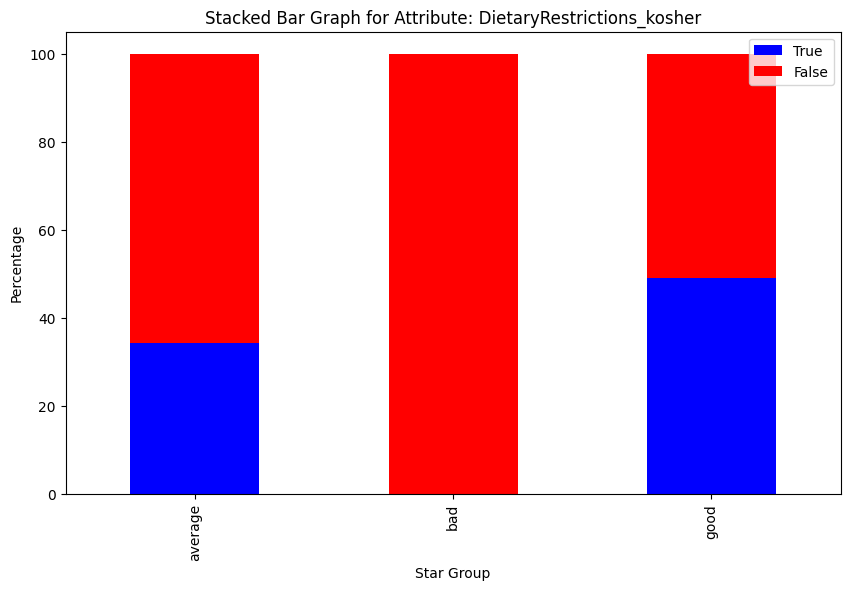

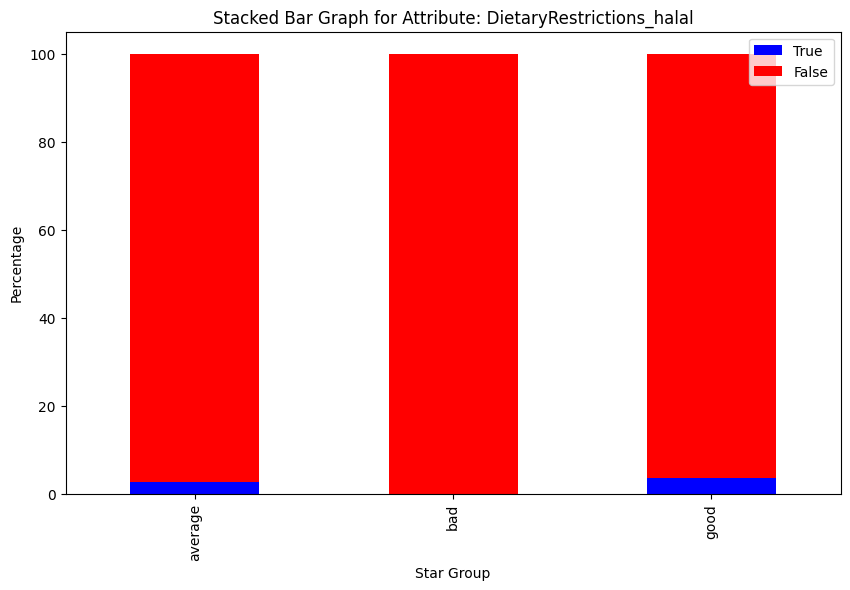

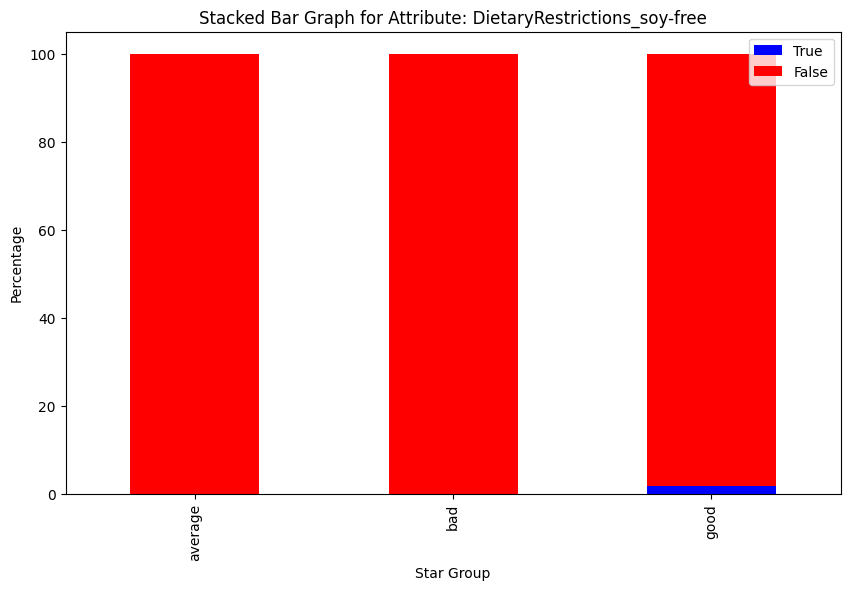

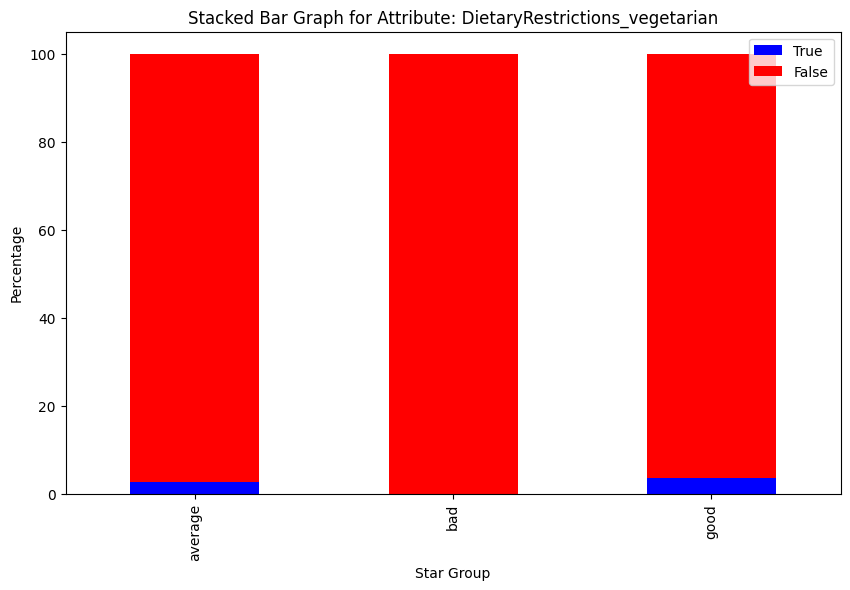

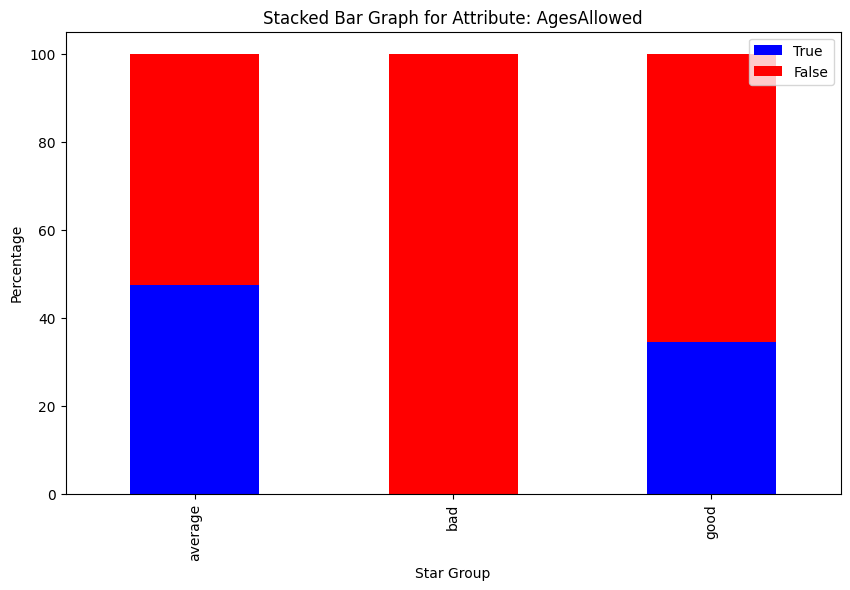

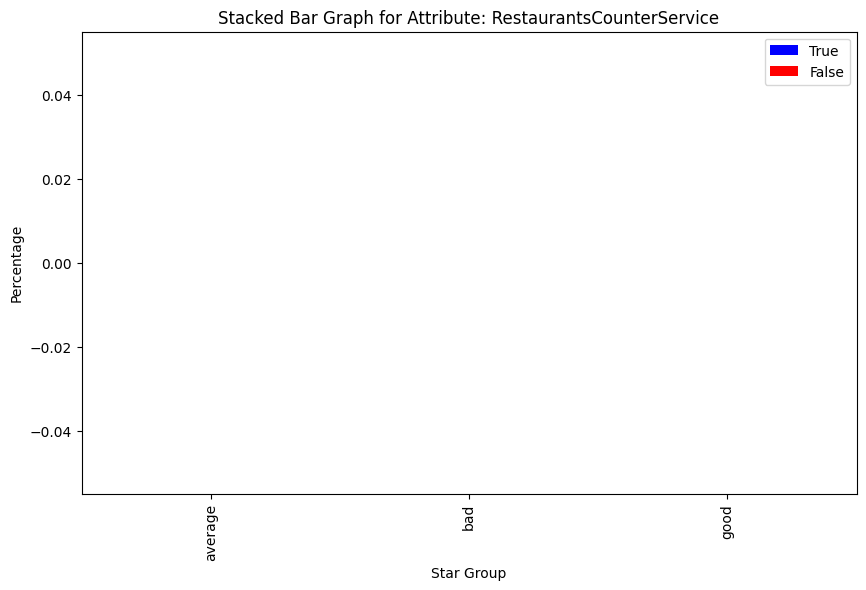

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("Stacked Bar Graph") \
    .getOrCreate()


file1_path = "/content/yelp_business_attributes.csv"
file2_path = "/content/yelp_business.csv"

df1 = spark.read.csv(file1_path, header=True, inferSchema=True)
df2 = spark.read.csv(file2_path, header=True, inferSchema=True)


merged_data = df1.join(df2, df1.business_id == df2.business_id, 'inner')

attributes_columns = [
    'AcceptsInsurance', 'ByAppointmentOnly', 'BusinessAcceptsCreditCards', 'BusinessParking_garage',
    'BusinessParking_street', 'BusinessParking_validated', 'BusinessParking_lot', 'BusinessParking_valet',
    'HairSpecializesIn_coloring', 'HairSpecializesIn_africanamerican', 'HairSpecializesIn_curly',
    'HairSpecializesIn_perms', 'HairSpecializesIn_kids', 'HairSpecializesIn_extensions',
    'HairSpecializesIn_asian', 'HairSpecializesIn_straightperms', 'RestaurantsPriceRange2',
    'GoodForKids', 'WheelchairAccessible', 'BikeParking', 'Alcohol', 'HasTV', 'NoiseLevel',
    'RestaurantsAttire', 'Music_dj', 'Music_background_music', 'Music_no_music', 'Music_karaoke',
    'Music_live', 'Music_video', 'Music_jukebox', 'Ambience_romantic', 'Ambience_intimate',
    'Ambience_classy', 'Ambience_hipster', 'Ambience_divey', 'Ambience_touristy', 'Ambience_trendy',
    'Ambience_upscale', 'Ambience_casual', 'RestaurantsGoodForGroups', 'Caters', 'WiFi',
    'RestaurantsReservations', 'RestaurantsTakeOut', 'HappyHour', 'GoodForDancing', 'RestaurantsTableService',
    'OutdoorSeating', 'RestaurantsDelivery', 'BestNights_monday', 'BestNights_tuesday', 'BestNights_friday',
    'BestNights_wednesday', 'BestNights_thursday', 'BestNights_sunday', 'BestNights_saturday',
    'GoodForMeal_dessert', 'GoodForMeal_latenight', 'GoodForMeal_lunch', 'GoodForMeal_dinner',
    'GoodForMeal_breakfast', 'GoodForMeal_brunch', 'CoatCheck', 'Smoking', 'DriveThru', 'DogsAllowed',
    'BusinessAcceptsBitcoin', 'Open24Hours', 'BYOBCorkage', 'BYOB', 'Corkage',
    'DietaryRestrictions_dairy-free', 'DietaryRestrictions_gluten-free', 'DietaryRestrictions_vegan',
    'DietaryRestrictions_kosher', 'DietaryRestrictions_halal', 'DietaryRestrictions_soy-free',
    'DietaryRestrictions_vegetarian', 'AgesAllowed', 'RestaurantsCounterService'
]

merged_data = merged_data.withColumn(
    'star_group',
    when(col('stars').between(0, 2.5), 'bad')
    .when(col('stars').between(2.6, 3.5), 'average')
    .when(col('stars').between(3.6, 5), 'good')
)

attribute_counts_true = {}
attribute_counts_false = {}

for attribute in attributes_columns:

    attribute_counts_true[attribute] = merged_data.groupBy('star_group').agg(
        spark_sum(col(attribute).cast('int')).alias(attribute)
    )

    attribute_counts_false[attribute] = merged_data.groupBy('star_group').agg(
        spark_sum((1 - col(attribute).cast('int'))).alias(attribute)
    )

combined_counts = {}

for col_name in attributes_columns:
    merged_data = merged_data.withColumn(
        col_name,
        col(col_name).cast('boolean')
    )

attribute_counts_true = {}
attribute_counts_false = {}

for attribute in attributes_columns:
    attribute_counts_true[attribute] = merged_data.groupBy('star_group').agg(
        spark_sum(col(attribute).cast('int')).alias(attribute)
    )

    attribute_counts_false[attribute] = merged_data.groupBy('star_group').agg(
        spark_sum((1 - col(attribute).cast('int'))).alias(attribute)
    )

combined_counts = {}

for attribute in attributes_columns:
    joined_counts = attribute_counts_true[attribute].join(
        attribute_counts_false[attribute], on='star_group', how='inner'
    ).toPandas()
    combined_counts[attribute] = joined_counts

for attribute, counts in combined_counts.items():
    counts.set_index('star_group', inplace=True)

    counts_percentage = counts.div(counts.sum(axis=1), axis=0) * 100

    ax = counts_percentage.plot(
        kind='bar',
        stacked=True,
        figsize=(10, 6),
        color=['blue', 'red'],
        label=['True', 'False']
    )

    plt.title(f'Stacked Bar Graph for Attribute: {attribute}')
    plt.xlabel('Star Group')
    plt.ylabel('Percentage')

    plt.legend(labels=['True', 'False'])

    plt.show()

spark.stop()


In [ ]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, avg, expr
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


spark = SparkSession.builder \
    .appName("Yelp Data Analysis and Modeling") \
    .getOrCreate()


yelp_attributes_path = "yelp_business_attributes.csv"
yelp_business_path = "yelp_business.csv"

df_attributes = spark.read.csv(yelp_attributes_path, header=True, inferSchema=True)
df_business = spark.read.csv(yelp_business_path, header=True, inferSchema=True)

merged_df = df_attributes.join(df_business, on="business_id", how="inner")

merged_df = merged_df.fillna({
    'AcceptsInsurance': 'False',
    'BusinessAcceptsCreditCards': 'False',
    'BusinessParking_garage': 'False',
    'BusinessParking_street': 'False',
    'BusinessParking_validated': 'False',
    'BusinessParking_lot': 'False',
    'BusinessParking_valet': 'False',
    'HairSpecializesIn_coloring': 'False',

    'WiFi': 'none',
    'RestaurantsPriceRange2': 1
})


categorical_columns = [
    'AcceptsInsurance',
    'BusinessAcceptsCreditCards',
    'BusinessParking_garage',
    'BusinessParking_street',
    'BusinessParking_validated',
    'BusinessParking_lot',
    'BusinessParking_valet',
    'HairSpecializesIn_coloring',

]

for col_name in categorical_columns:
    merged_df = merged_df.withColumn(col_name, when(col(col_name) == 'True', 1).otherwise(0))


categorical_columns_to_encode = [
    'WiFi',
    'RestaurantsPriceRange2',

]

for col_name in categorical_columns_to_encode:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_indexed")
    merged_df = indexer.fit(merged_df).transform(merged_df)


feature_columns = categorical_columns + [f"{col_name}_indexed" for col_name in categorical_columns_to_encode]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(merged_df)

data = data.withColumn("target", when(col("stars") >= 4.0, 1).otherwise(0))

train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

rf = RandomForestClassifier(featuresCol="features", labelCol="target")

param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

cross_validator = CrossValidator(estimator=rf,
                                 estimatorParamMaps=param_grid,
                                 evaluator=MulticlassClassificationEvaluator(labelCol="target", metricName="accuracy"),
                                 numFolds=5)

cv_model = cross_validator.fit(train_data)

predictions = cv_model.transform(test_data)


evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy:.4f}")


spark.stop()


Model Accuracy: 0.6449


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, avg, expr
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


spark = SparkSession.builder \
    .appName("Yelp Data Analysis and Modeling") \
    .getOrCreate()


yelp_attributes_path = "yelp_business_attributes.csv"
yelp_business_path = "yelp_business.csv"

df_attributes = spark.read.csv(yelp_attributes_path, header=True, inferSchema=True)
df_business = spark.read.csv(yelp_business_path, header=True, inferSchema=True)

merged_df = df_attributes.join(df_business, on="business_id", how="inner")

merged_df = merged_df.fillna({
    'AcceptsInsurance': 'False',
    'BusinessAcceptsCreditCards': 'False',
    'BusinessParking_garage': 'False',
    'BusinessParking_street': 'False',
    'BusinessParking_validated': 'False',
    'BusinessParking_lot': 'False',
    'BusinessParking_valet': 'False',
    'HairSpecializesIn_coloring': 'False',

    'WiFi': 'none',
    'RestaurantsPriceRange2': 1
})

categorical_columns = [
    'AcceptsInsurance',
    'BusinessAcceptsCreditCards',
    'BusinessParking_garage',
    'BusinessParking_street',
    'BusinessParking_validated',
    'BusinessParking_lot',
    'BusinessParking_valet',
    'HairSpecializesIn_coloring',

]

for col_name in categorical_columns:
    merged_df = merged_df.withColumn(col_name, when(col(col_name) == 'True', 1).otherwise(0))


categorical_columns_to_encode = [
    'WiFi',
    'RestaurantsPriceRange2',

]

for col_name in categorical_columns_to_encode:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_indexed")
    merged_df = indexer.fit(merged_df).transform(merged_df)


feature_columns = categorical_columns + [f"{col_name}_indexed" for col_name in categorical_columns_to_encode]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(merged_df)

data = data.withColumn("target", when(col("stars") >= 4.0, 1).otherwise(0))

train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

rf = RandomForestClassifier(featuresCol="features", labelCol="target")

param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

cross_validator = CrossValidator(estimator=rf,
                                 estimatorParamMaps=param_grid,
                                 evaluator=MulticlassClassificationEvaluator(labelCol="target", metricName="accuracy"),
                                 numFolds=5)

cv_model = cross_validator.fit(train_data)

predictions = cv_model.transform(test_data)


accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy:.4f}")


regression_evaluator = RegressionEvaluator(labelCol="stars", predictionCol="prediction")

rmse = regression_evaluator.evaluate(predictions, {regression_evaluator.metricName: "rmse"})
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

mae = regression_evaluator.evaluate(predictions, {regression_evaluator.metricName: "mae"})
print(f"Mean Absolute Error (MAE): {mae:.4f}")

r_squared = regression_evaluator.evaluate(predictions, {regression_evaluator.metricName: "r2"})
print(f"R-squared: {r_squared:.4f}")

spark.stop()


Classification Report:
              precision    recall  f1-score   support

     average       0.46      0.13      0.20      9880
         bad       0.56      0.05      0.09      5366
        good       0.51      0.92      0.66     15163

    accuracy                           0.51     30409
   macro avg       0.51      0.37      0.32     30409
weighted avg       0.50      0.51      0.41     30409



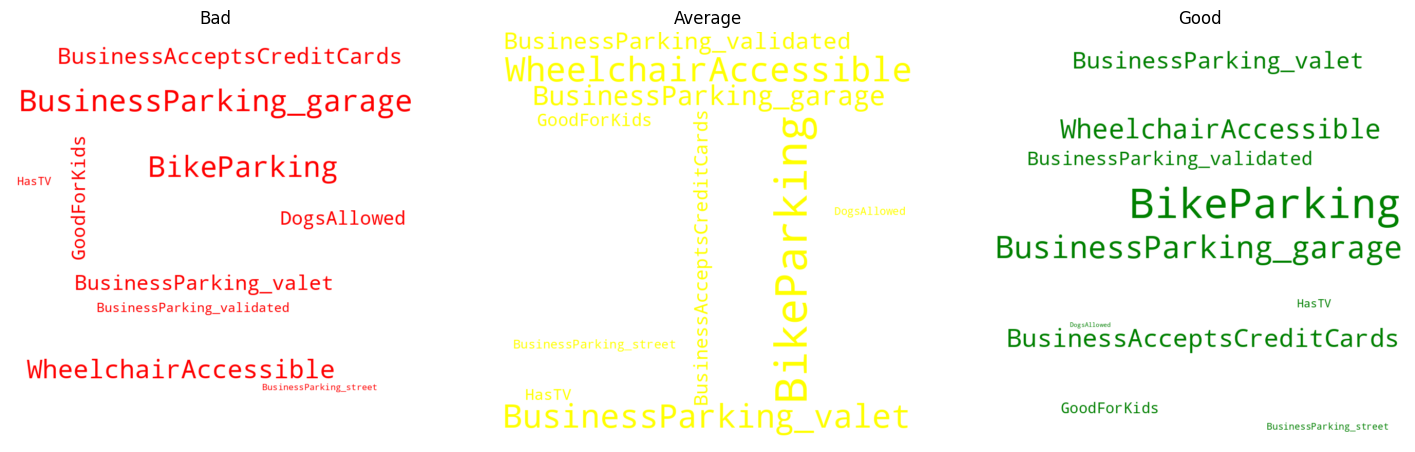

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from wordcloud import WordCloud
import matplotlib.pyplot as plt

yelp_business_csv = 'yelp_business.csv'
yelp_business_attributes_csv = 'yelp_business_attributes.csv'


business_df = pd.read_csv(yelp_business_csv)
attributes_df = pd.read_csv(yelp_business_attributes_csv)

merged_df = pd.merge(business_df, attributes_df, on='business_id')


def categorize_stars(stars):
    if stars < 3.0:
        return 'bad'  # 1-2.9 stars
    elif stars < 4.0:
        return 'average'  # 3-3.9 stars
    else:
        return 'good'  # 4-5 stars

merged_df['rating_category'] = merged_df['stars'].apply(categorize_stars)


def binary_encode(series):

    series_lower = series.str.lower()

    encoded_series = series_lower.map(lambda x: 0 if x in ['no', 'false', 'na', 'nan'] else 1)
    return encoded_series.astype(int)

binary_columns = [
    'AcceptsInsurance', 'ByAppointmentOnly', 'BusinessAcceptsCreditCards',
    'BusinessParking_garage', 'BusinessParking_street',
    'BusinessParking_validated', 'BusinessParking_lot',
    'BusinessParking_valet', 'WheelchairAccessible', 'BikeParking',
    'HasTV', 'Music_dj', 'Music_background_music', 'Music_no_music',
    'Music_karaoke', 'Music_live', 'Music_video', 'Music_jukebox',
    'HappyHour', 'GoodForDancing', 'OutdoorSeating', 'RestaurantsTakeOut',
    'RestaurantsDelivery', 'GoodForKids', 'CoatCheck', 'Smoking',
    'DriveThru', 'DogsAllowed', 'BusinessAcceptsBitcoin', 'Open24Hours',
    'BYOBCorkage', 'BYOB', 'Corkage', 'WiFi'
]


for column in binary_columns:
    merged_df[column] = binary_encode(merged_df[column])

X = merged_df[binary_columns]
y = merged_df['rating_category']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred))


selector = SelectKBest(chi2, k=10)
selector.fit(X_train_scaled, y_train)
top_attributes_indices = selector.get_support(indices=True)
top_attributes = [binary_columns[i] for i in top_attributes_indices]


rating_categories = ['bad', 'average', 'good']
rating_colors = ['red', 'yellow', 'green']


word_count = {'bad': {}, 'average': {}, 'good': {}}


for category in rating_categories:
    # Filter the data based on the rating category
    X_category = X_train[y_train == category]

    for idx in top_attributes_indices:
        attribute = binary_columns[idx]
        if attribute in X_category.columns:

            count = X_category[attribute].sum()

            word_count[category][attribute] = count

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, category in enumerate(rating_categories):

    wordcloud = WordCloud(width=800, height=800, background_color='white',
                          color_func=lambda *args, **kwargs: rating_colors[i])
    wc = wordcloud.generate_from_frequencies(word_count[category])

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(category.title())
    axes[i].axis('off')

plt.show()

#If it was yes, true, and anything other than no, false, nan, or na.